In [1]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx

from utils.visualization_utils import *


%matplotlib inline

#filename = '/eos/home-j/jejarosl/test_sample_pion140pu/new_ntuples_15459280_525.root'
filename = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/TICLv4Sample/GNNTraining/SingleGamma140PU/ntuples_10_600/new_ntuples_15459279_533.root"

In [2]:
 file = uproot.open(filename)

In [3]:
tracks = file["ticlNtuplizer/tracks"]
tracksters = file["ticlNtuplizer/tracksters"]
simtracksters = file["ticlNtuplizer/simtrackstersSC"]
ass = file["ticlNtuplizer/associations"]
gra = file["ticlNtuplizer/graph"]
cand = file["ticlNtuplizer/candidates"]
lc = file["ticlNtuplizer/clusters"]

In [7]:
ev = 0

trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy", "layer_cluster_seed"])[ev]
gra_data = gra.arrays(["linked_inners", "linked_outers"])[ev]
ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
                       "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])[ev]
simtrackstersSC_data = simtracksters.arrays("stsSC_raw_energy")[ev]
cand_data = cand.arrays(["tracksters_in_candidate"])[ev]
lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy'])[ev]

In [18]:
vx = trk_data.vertices_x
vy = trk_data.vertices_y
vz = trk_data.vertices_z
ve = trk_data.vertices_energy
vi = trk_data.vertices_indexes

vx_sim = simtracksters["stsSC_vertices_x"].array()[ev]
vy_sim = simtracksters["stsSC_vertices_y"].array()[ev]
vz_sim = simtracksters["stsSC_vertices_z"].array()[ev]
ve_sim = simtracksters["stsSC_vertices_energy"].array()[ev]

bx = trk_data.barycenter_x
by = trk_data.barycenter_y
bz = trk_data.barycenter_z
be = trk_data.raw_energy

bx_sim = simtracksters["stsSC_barycenter_x"].array()[ev]
by_sim = simtracksters["stsSC_barycenter_y"].array()[ev]
bz_sim = simtracksters["stsSC_barycenter_z"].array()[ev]
be_sim = simtracksters["stsSC_raw_energy"].array()[ev]

In [8]:
def get_major_PU_tracksters(
    reco2sim,
    sim_raw_energy,
    score_threshold=0.2,
    energy_fraction_threshold=0.3
):
    # assuming only one simtrackster to keep things easy
    big = []

    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(reco2sim):
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            # 2 goals here:
            # - find the trackster with >50% shared energy
            # - find the tracksters with < 0.2 score
            if score > score_threshold: continue

            st_energy = sim_raw_energy[simT_idx]
            st_fraction = shared_energy / st_energy
            
            if st_fraction > energy_fraction_threshold:
                big.append(recoT_idx)

    return big

In [9]:
reco2sim_index = ass_data.tsCLUE3D_recoToSim_SC
reco2sim_score = ass_data.tsCLUE3D_recoToSim_SC_score
reco2sim_sharedE = ass_data.tsCLUE3D_recoToSim_SC_sharedE
sim_raw_energy = simtrackstersSC_data.stsSC_raw_energy

In [10]:
bigTracksters = get_major_PU_tracksters(
    zip(reco2sim_index, reco2sim_sharedE, reco2sim_score),
    sim_raw_energy,
)

In [11]:
bigTracksters

[398]

In [12]:
def find_dist_to_closest_edge(point, edges, far=False):
    """
    point: np.array (x,y,z)
    edges: dictionary
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    closest_endpoint_id = None
    
    for edge, (segment_start, segment_end) in edges.items():
        
        if far: 
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp, far_endpoint, far_endpoint_id = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        else:
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        
        if dist < min_dist:
            min_dist = dist
            min_edge = edge
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            closest_endpoint_id = closest_endpoint_id_tmp
        
    if far:
        return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
            
    return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id

def distance_point_to_segment(point, segment_start, segment_end, edge, far=False):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    point_vector = point - segment_start
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        if far:
            return np.linalg.norm(point_vector), segment_start, segment_start, edge[0], segment_end, edge[1] 
        return np.linalg.norm(point_vector), segment_start, segment_start, edge[0]
    elif projection > 1:
        if far:
             return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1], segment_start, edge[0]
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1]
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        closest_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else edge[1]
        
        if far:
            far_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else segment_end
            far_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else edge[1]
            return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id
    
def explored_nodes_affected(nodes, edges, DST_threshold):
    for n, point in nodes.items():
        # go through all explored nodes
        # go through all edges
        min_dist = np.inf
        for edge, (segment_start, segment_end) in edges.items():
        
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge)
            # find minimal distance
            if dist < min_dist:
                min_dist = dist
                
        # check that minimal distance is lower than the threshold
        if min_dist > DST_threshold:
            return True
        
    return False

def closer_to_seed(point, closest_endpoint, seed_coord):
    if np.linalg.norm(point - seed_coord) <  np.linalg.norm(closest_endpoint - seed_coord):
        return True
    return False

In [14]:
def project_lc_to_pca(point, segment_start, segment_end):
    """
    `lc` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    #print(segment_vector)
    point_vector = point - segment_start
    #print(point_vector)
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    closest_point = segment_start + projection * segment_vector
    return np.linalg.norm(point - closest_point), closest_point

In [15]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [51]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [52]:
!pip install wpca
from wpca import WPCA, EMPCA

Defaulting to user installation because normal site-packages is not writeable


In [53]:
def create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR = 1.5, MAX_ITER=None, sort_by_z = False):
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    lcx = lc_data.position_x
    lcy = lc_data.position_y
    lcz = lc_data.position_z
    lce = lc_data.energy

    bubble_size = 10
    pileup_alpha = 0.5
    noise_threshold = 0.2

    for bigT in bigTracksters:

        vxt = vx[bigT]
        vyt = vy[bigT]
        vzt = vz[bigT]
        vet = ve[bigT]
        vit = vi[bigT]
        edges, nodes = {}, {}

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")
        seed_lc_idx = trk_data.layer_cluster_seed[bigT]
        ax.scatter(lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx], s=lce[seed_lc_idx]*bubble_size/2, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        # go through the layers of the trackster: a) in increasing z-component b) by increasing energy
        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]
        
        if sort_by_z:
            # sorted by z
            ordered_data = sorted(data, key=lambda a: -a[2])
        else: 
            # sorted by energy
            ordered_data = sorted(data, key=lambda a: -a[3])

        txt = range(len(ordered_data))
        txt_i = 0
        
        seed_coord = np.array([lcx[seed_lc_idx], lcy[seed_lc_idx], lcz[seed_lc_idx]])
        edges[(-1, -1)] = (seed_coord, seed_coord)

        for x, y, z, e, i, j in ordered_data:

            # Check how far the new node is from the current edges
            point = np.array([x, y, z])
            min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id =  find_dist_to_closest_edge(point, edges, far=True)

            if min_dist > DST_threshold:
                # refine the graph

                if closer_to_seed(point, closest_endpoint, seed_coord):
                    
                    
                    if min_edge == (-1, -1):
                        affected = True
                    else:
                        edge_angle = angle_between(np.array(point - edges[min_edge][0]), point - edges[min_edge][1])
                        
                        if abs(edge_angle) < ANGLE_THR:
                            affected = True
                            continue 
                            
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        new_edges[(min_edge[1], j)] = (edges[min_edge][1], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    #print(affected)

                    if not affected:
                        #print('not affected')
                        edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        edges[(min_edge[1], j)] = (edges[min_edge][1], point)

                        # drop the closest edge
                        del edges[min_edge]
                else:
                    
                    # Can refine? What if I remove closest endpoint and directly connect to a new node?
                    if far_endpoint_id != -1:
                        affected = True
                    else:
                        # input new edges
                        new_edges = edges.copy()
                        new_edges[(min_edge[0], j)] = (edges[min_edge][0], point)
                        del new_edges[min_edge]
                        affected = explored_nodes_affected(nodes, new_edges, DST_threshold)
                    
                    if not affected:
                        
                        edges[(far_endpoint_id, j)] = (far_endpoint, point)
                        del edges[min_edge]
                        
                    else:
                        edges[(closest_endpoint_id, j)] = (closest_endpoint, point)

                #print(txt_i, (closest_endpoint_id, j), ' energy: ', e)

#             else:
#                 print("close enough: ", txt_i, ' energy: ', e)

            #print('-------------')
    
            # othervise we ignore it

            ax.text(x, y, z, txt[txt_i])

            nodes[j] = point
            
            txt_i += 1
            if MAX_ITER and txt_i == MAX_ITER:
                break

        all_edges.append(edges)
        all_nodes.append(nodes)
        break
        
    for edge, (segment_start, segment_end) in edges.items():
        plt.plot((segment_start[0], segment_end[0]), (segment_start[1], segment_end[1]), (segment_start[2], segment_end[2]), c='b', alpha=0.6)

    set_axes_equal(ax)
    ax.view_init(azim=90, elev=0)
    plt.show()

In [56]:
%matplotlib widget
create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR = 1.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
%matplotlib widget
create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR = 1.5, sort_by_z = True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

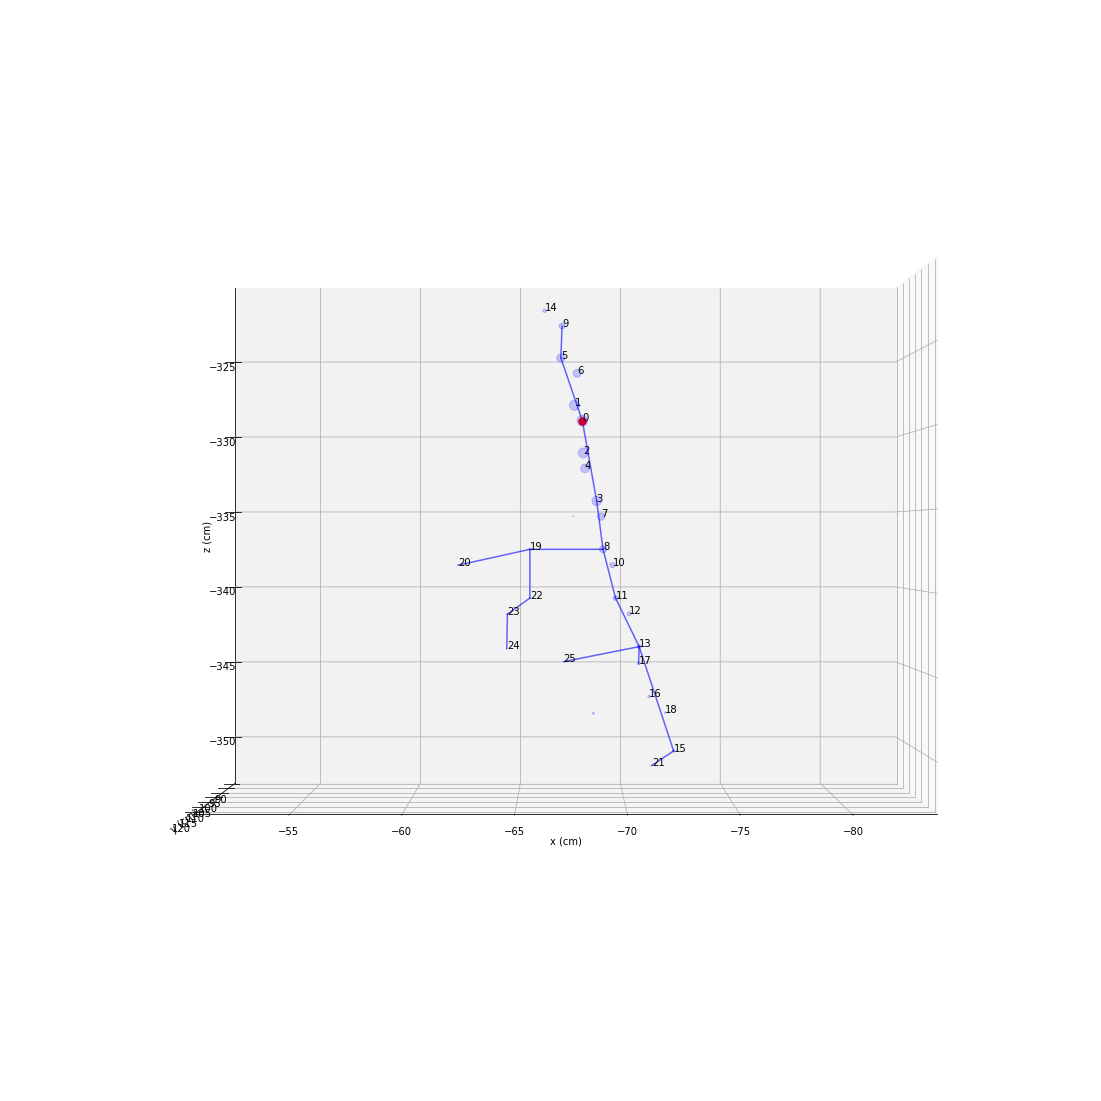

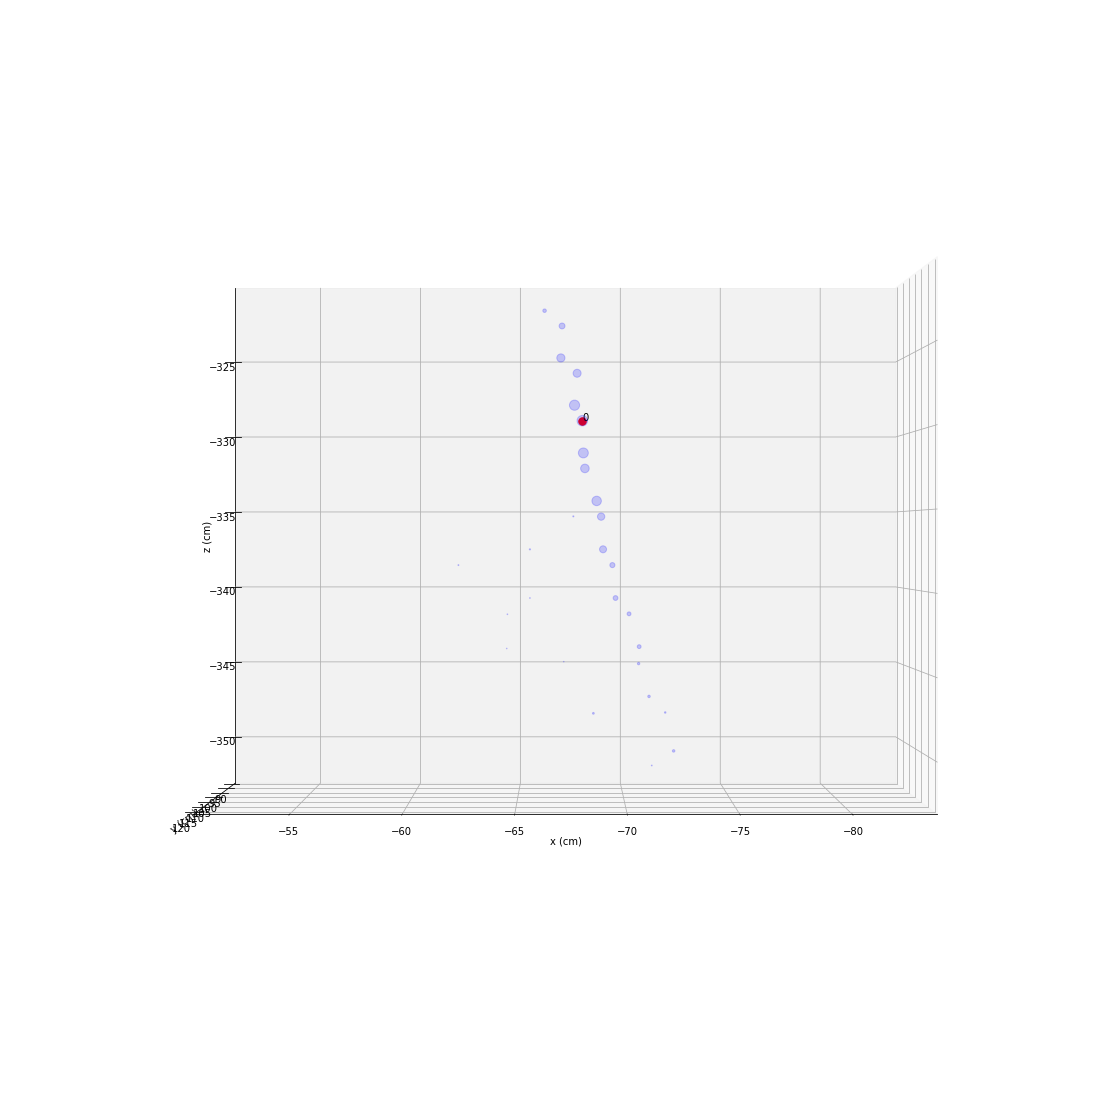

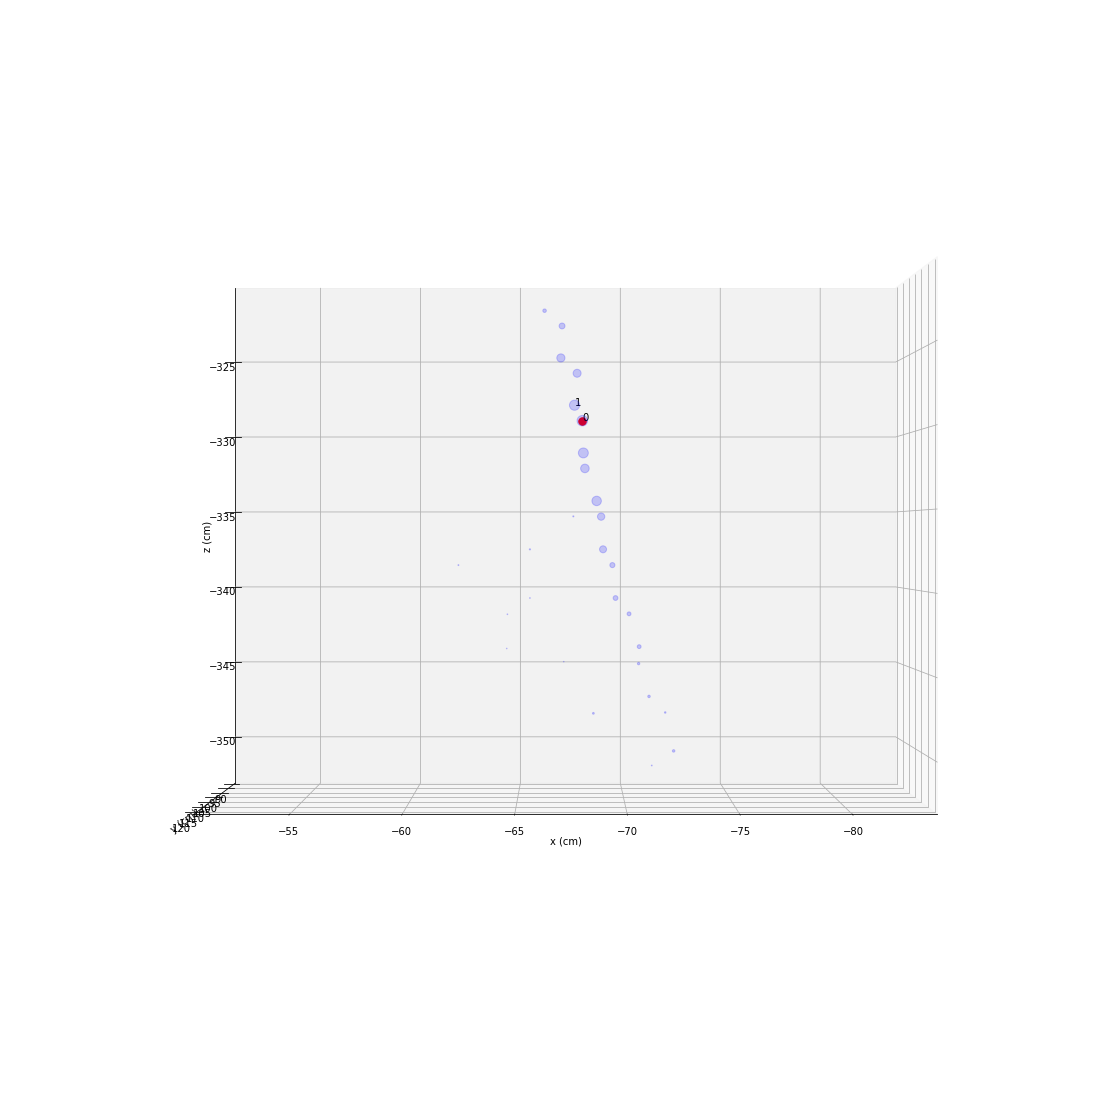

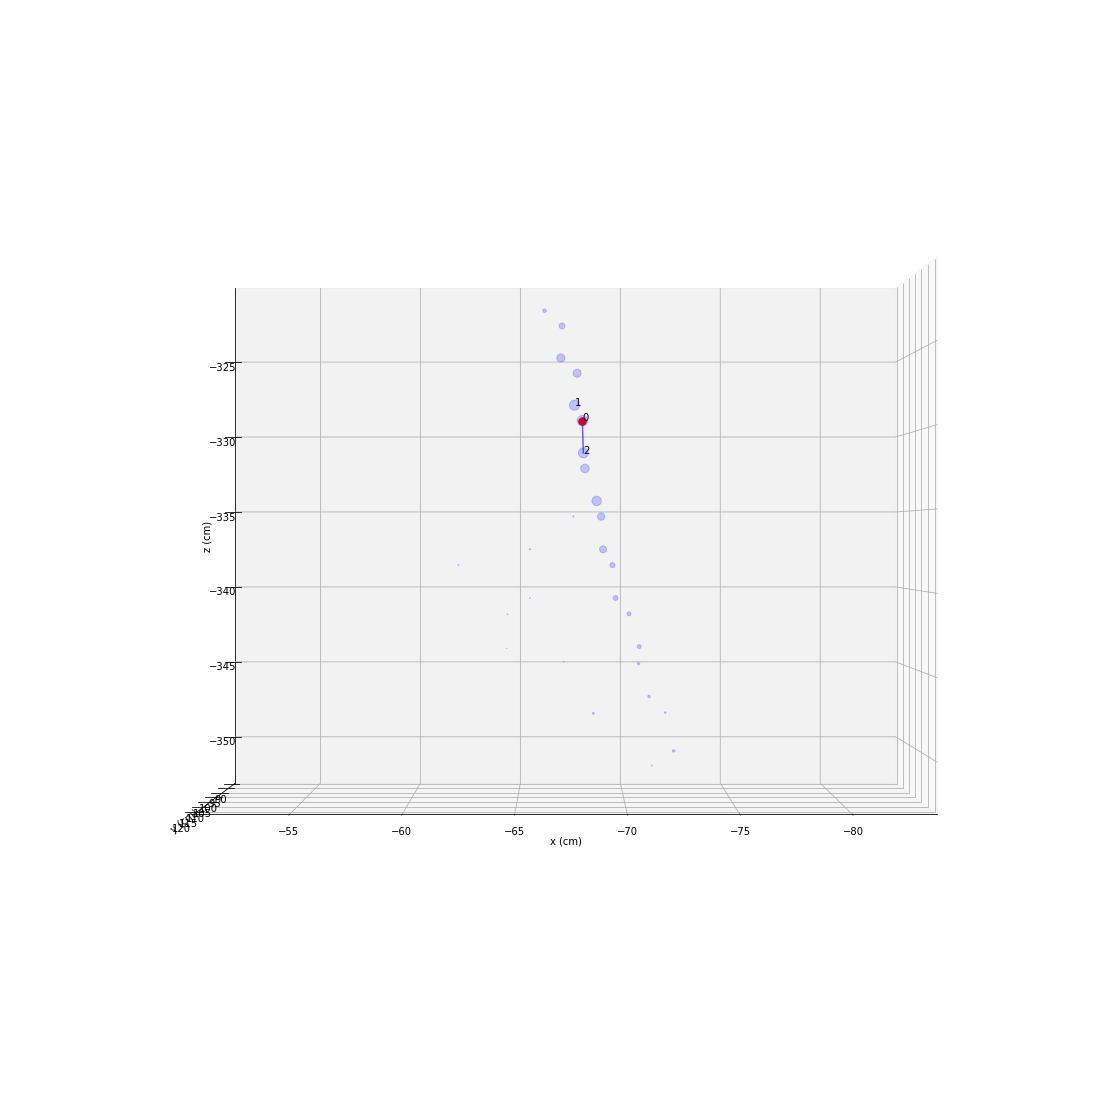

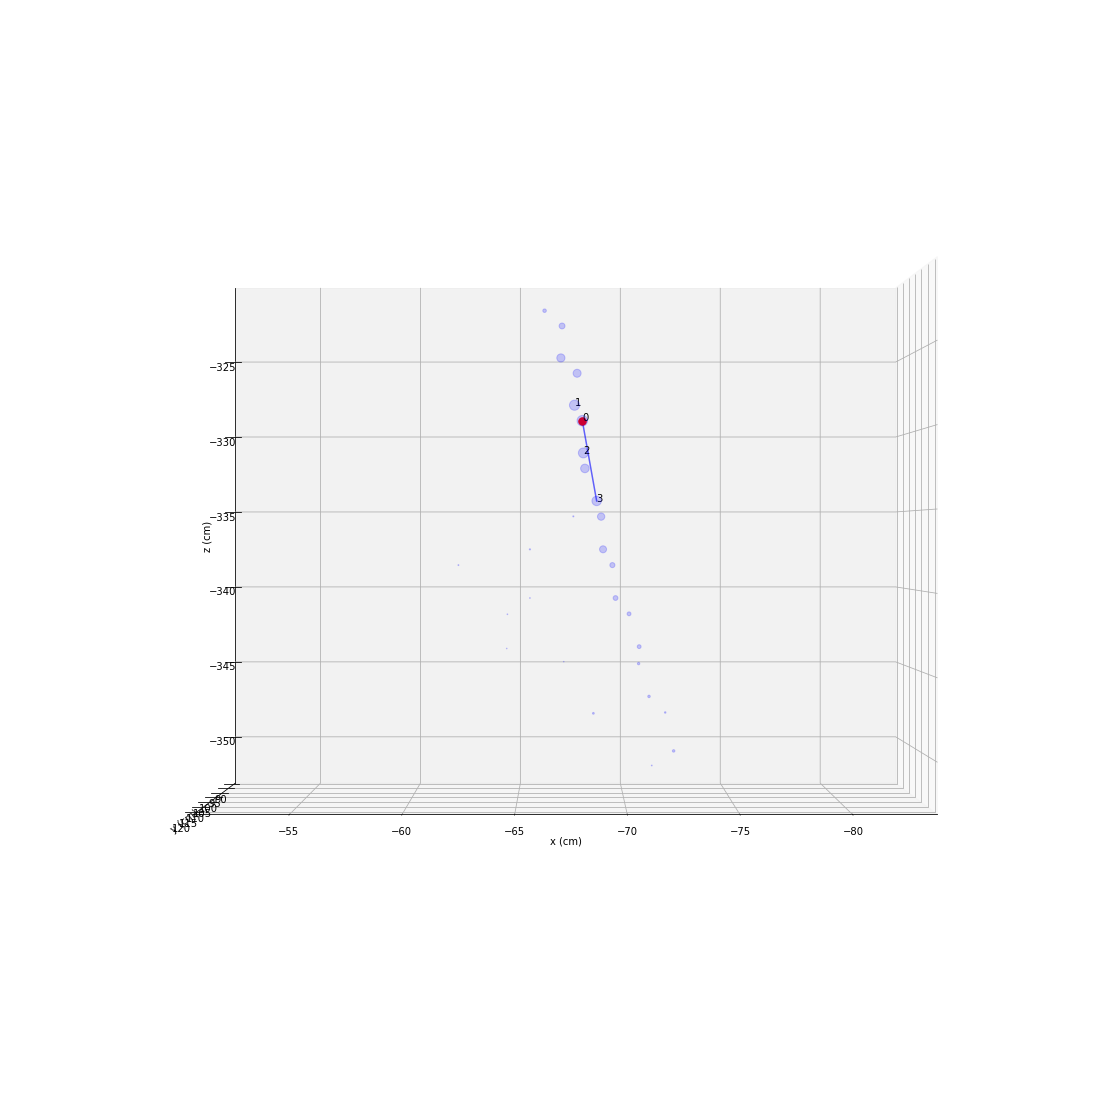

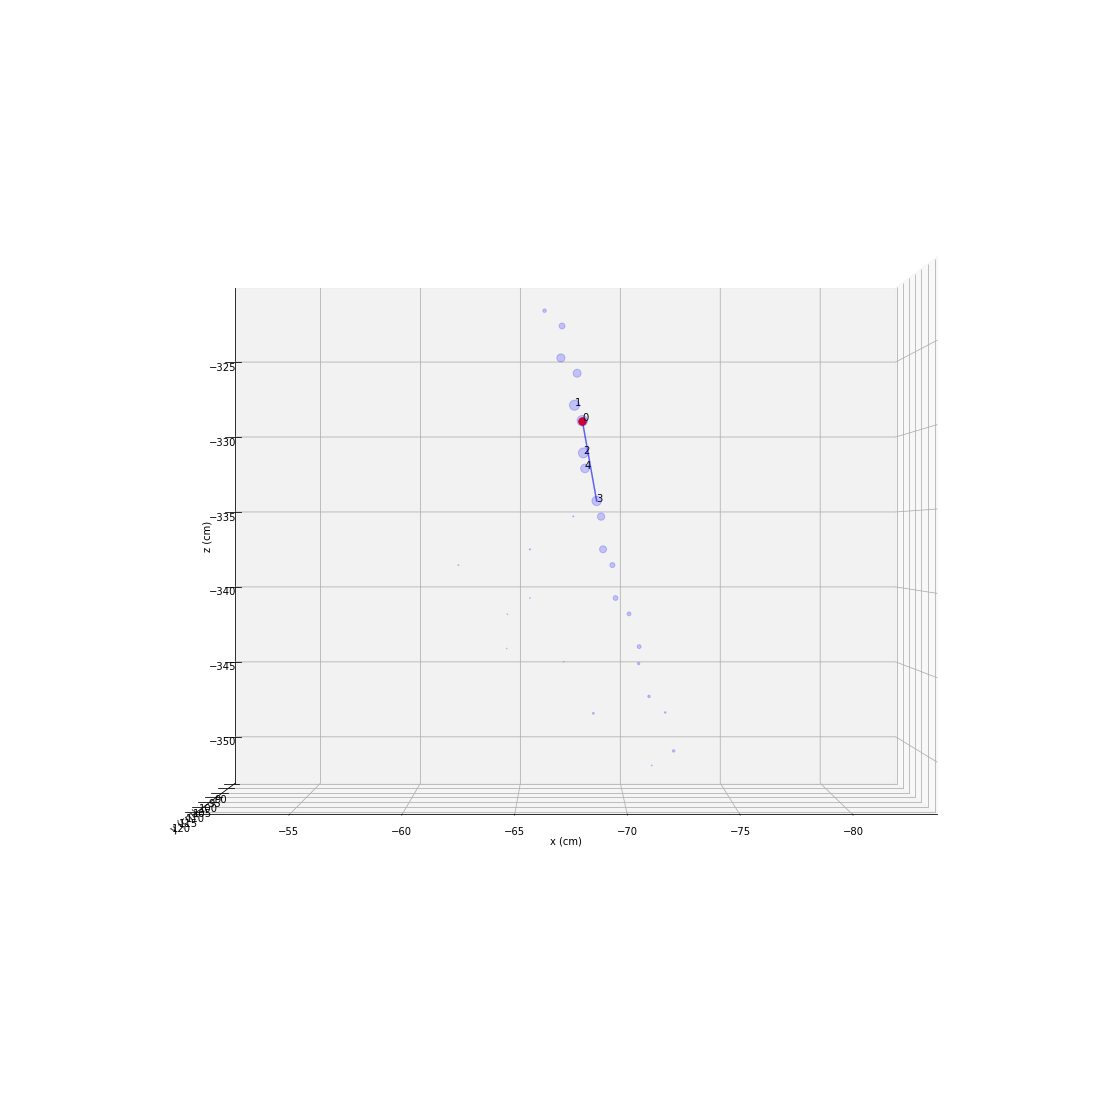

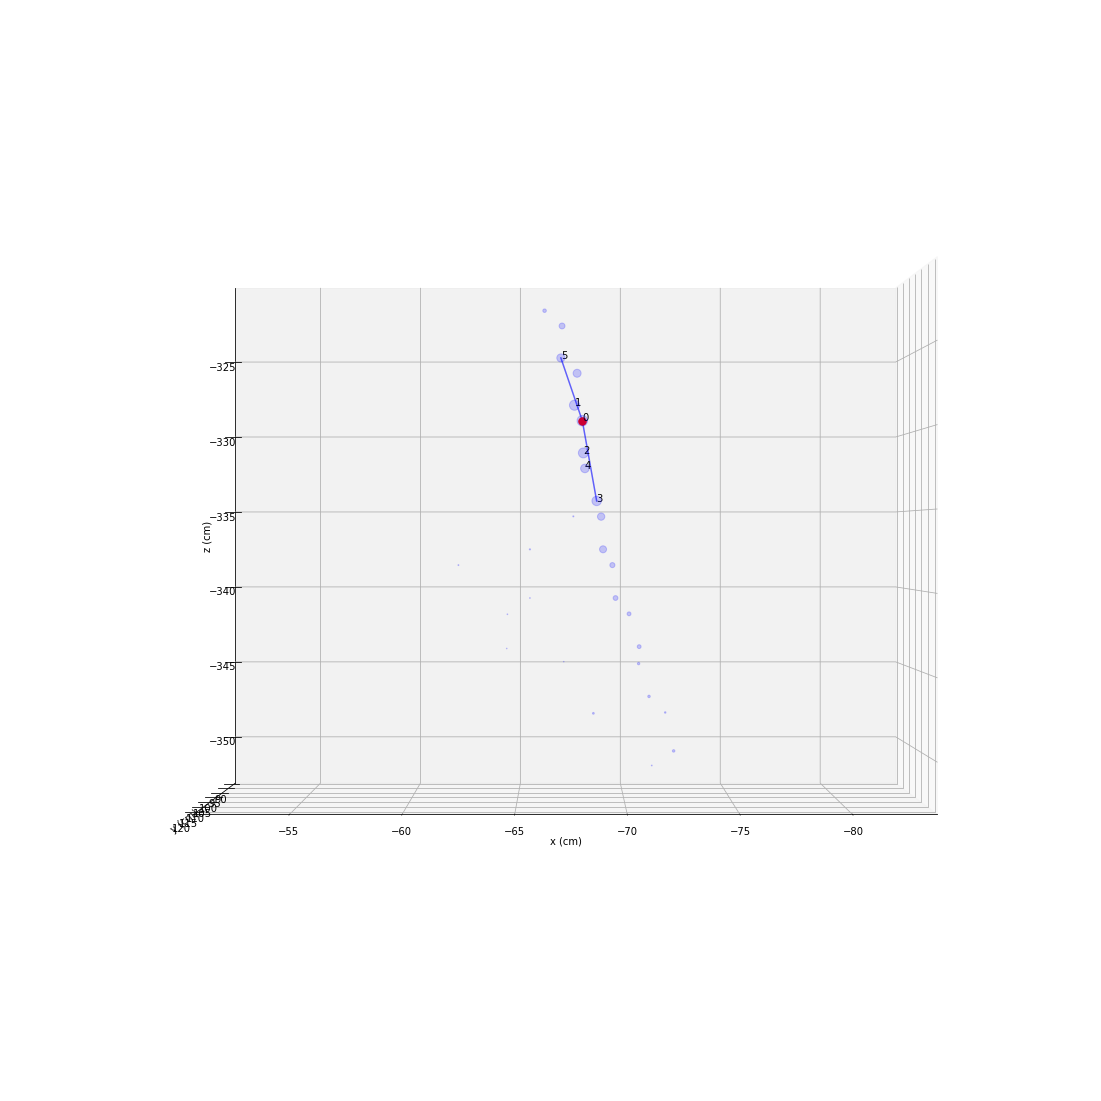

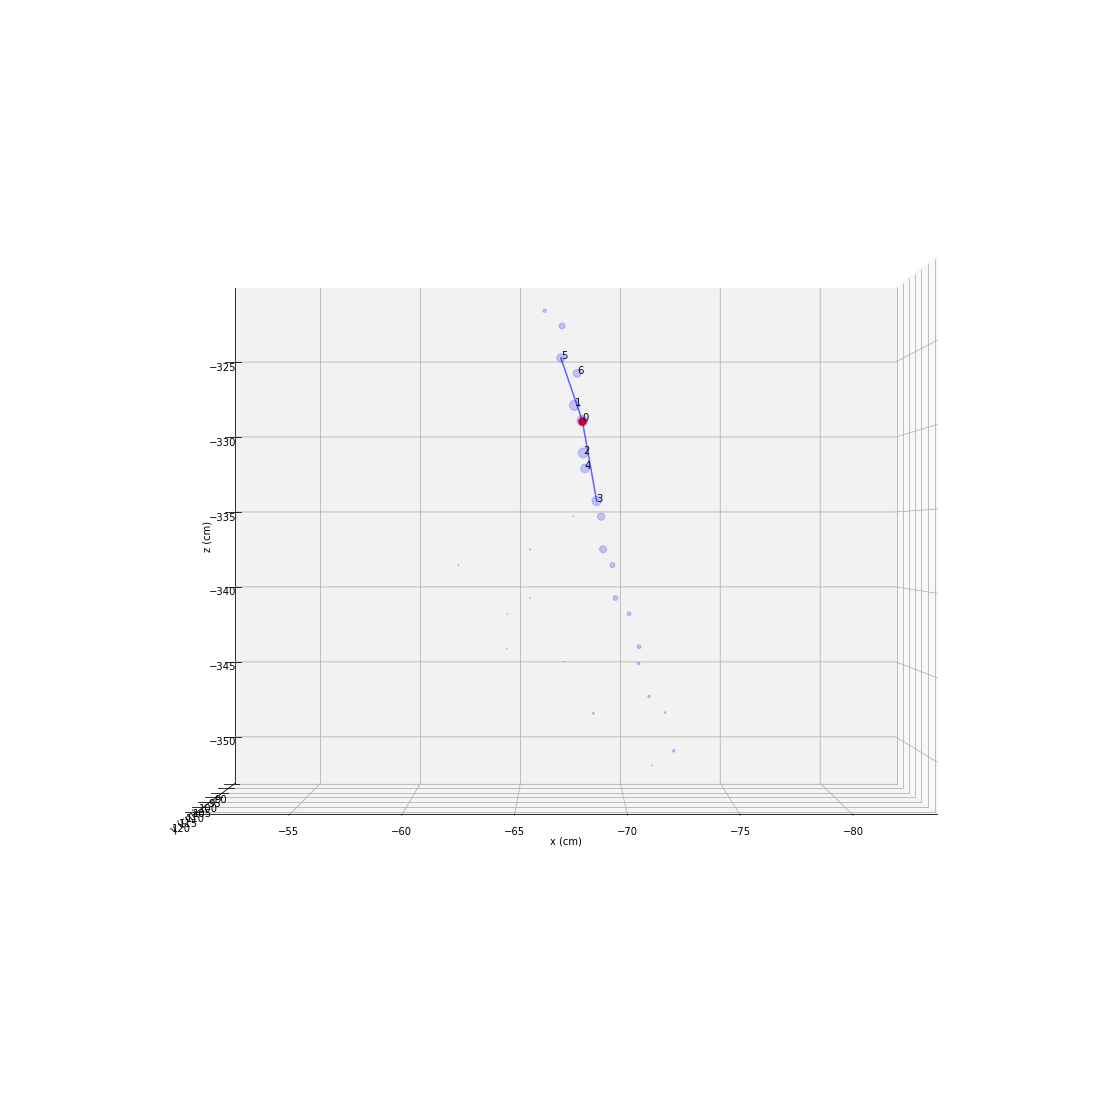

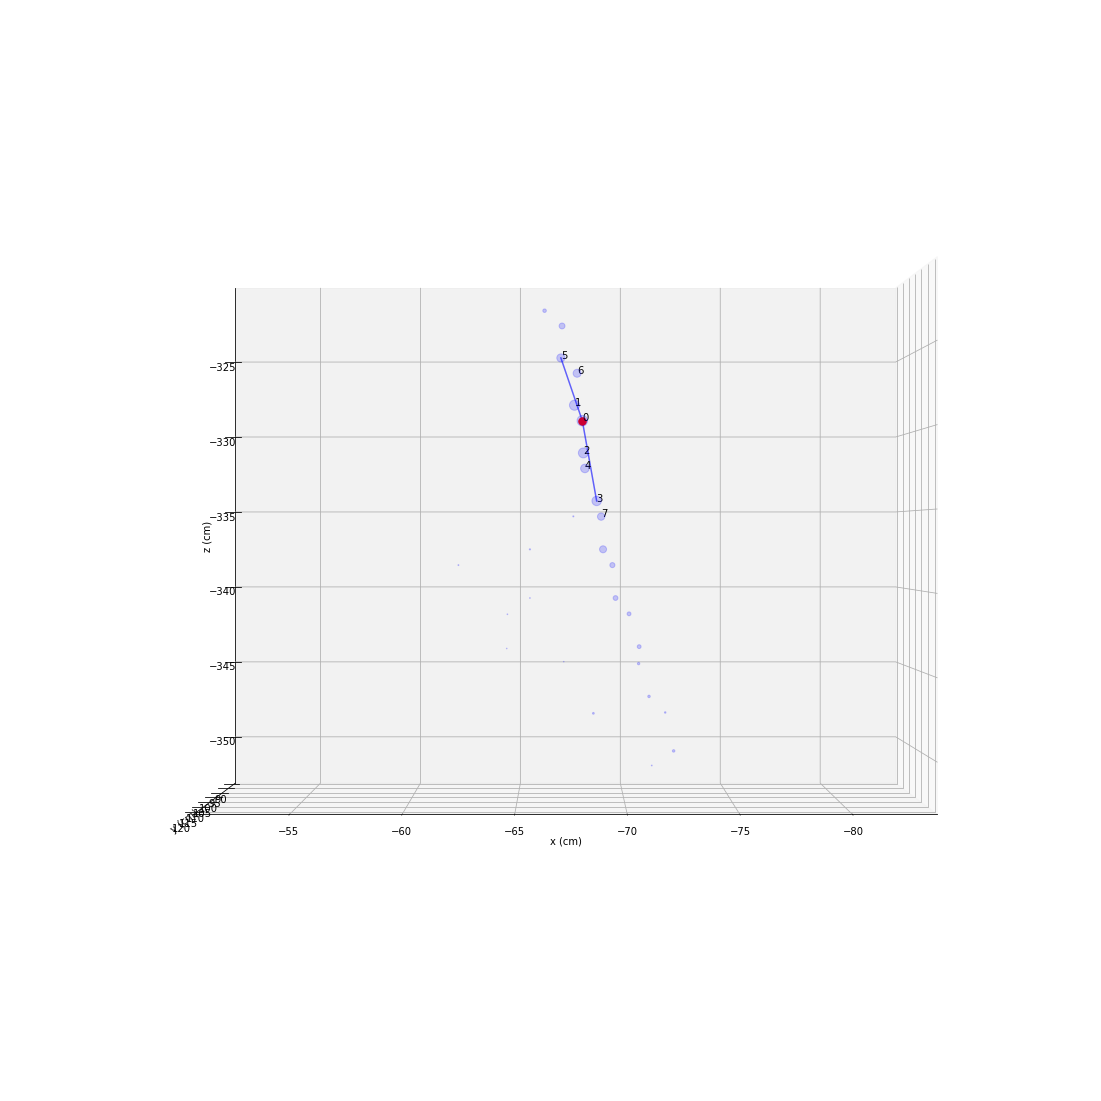

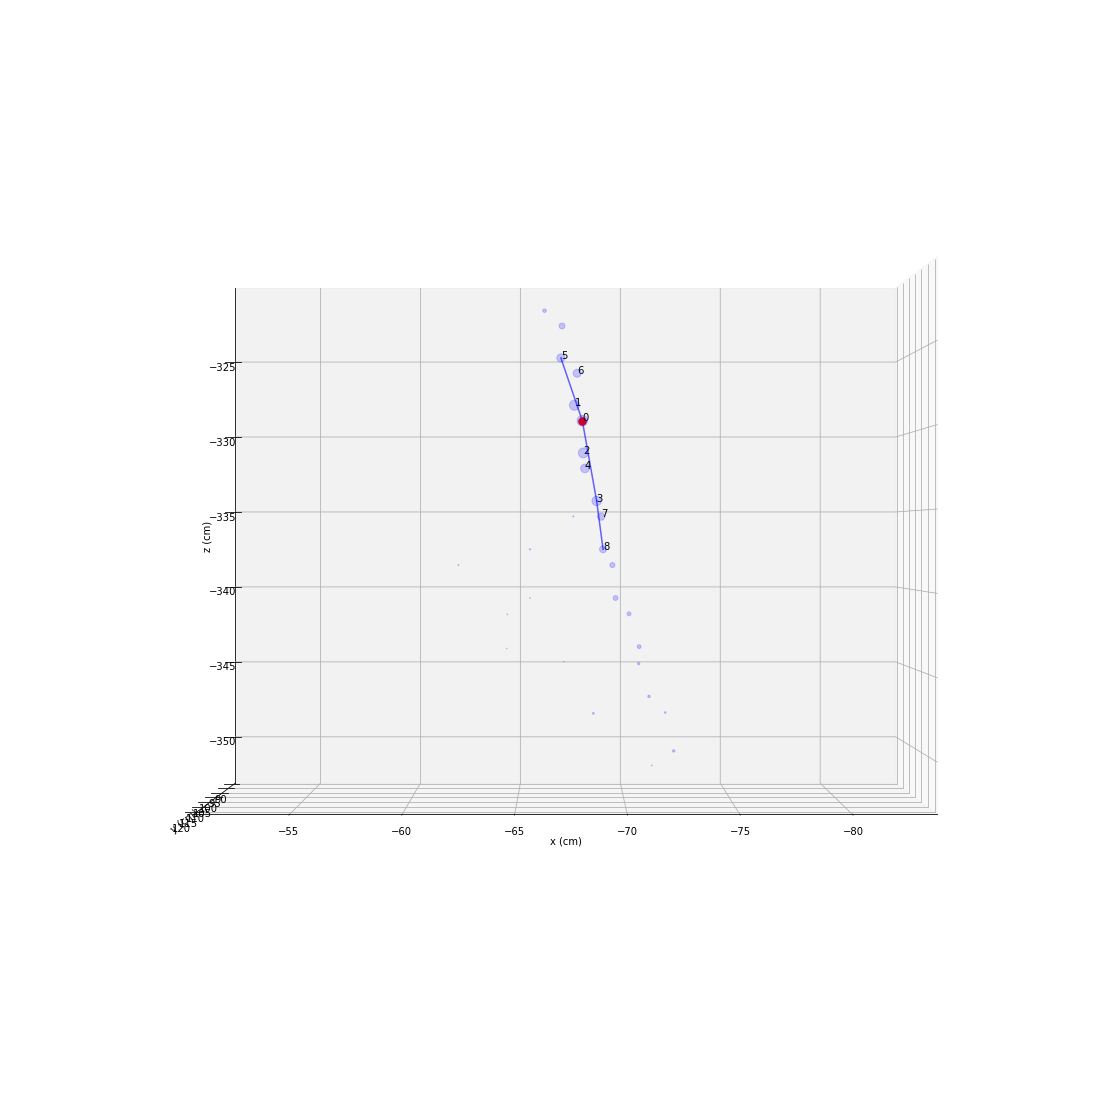

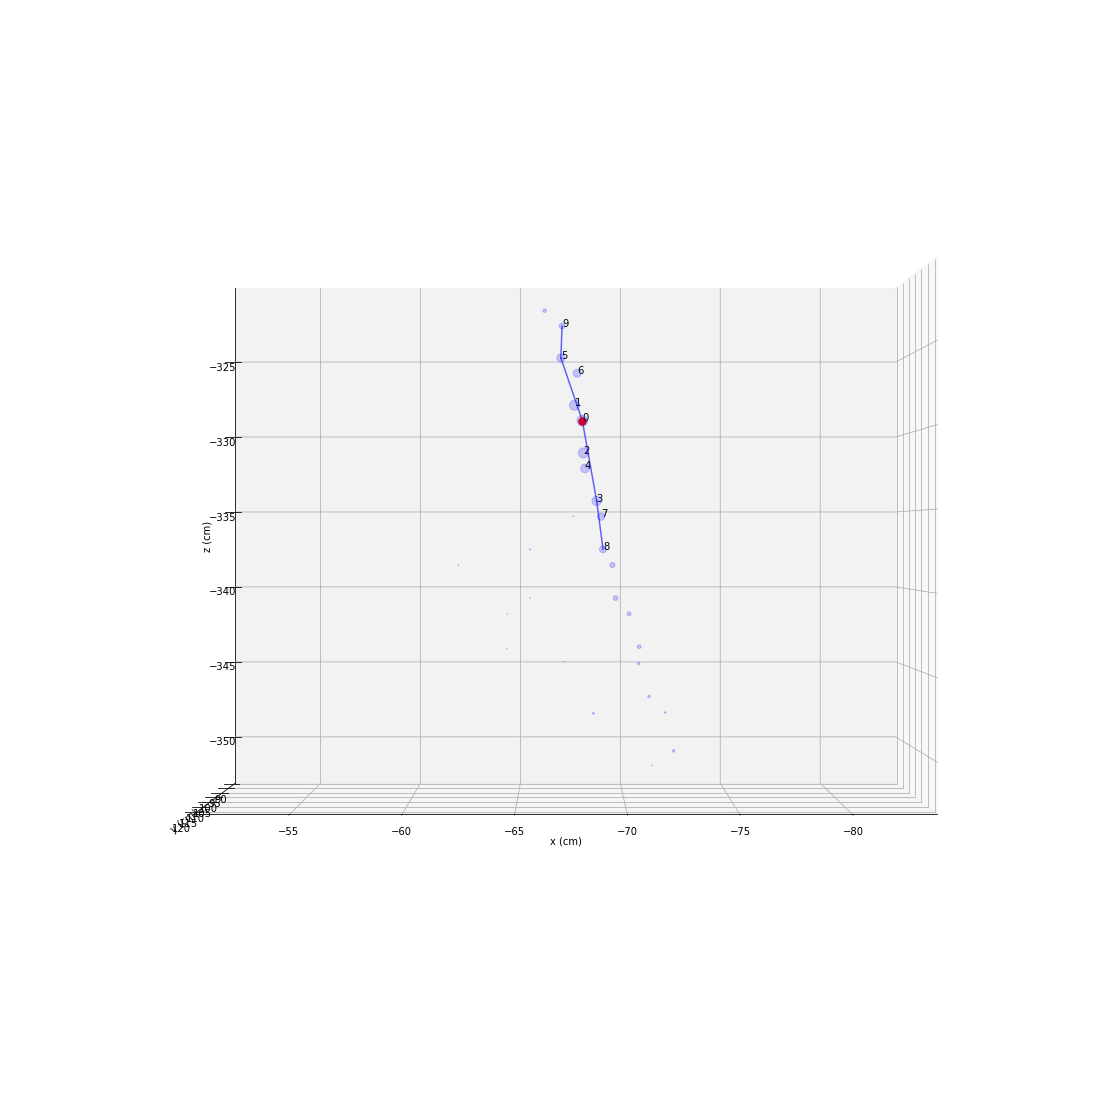

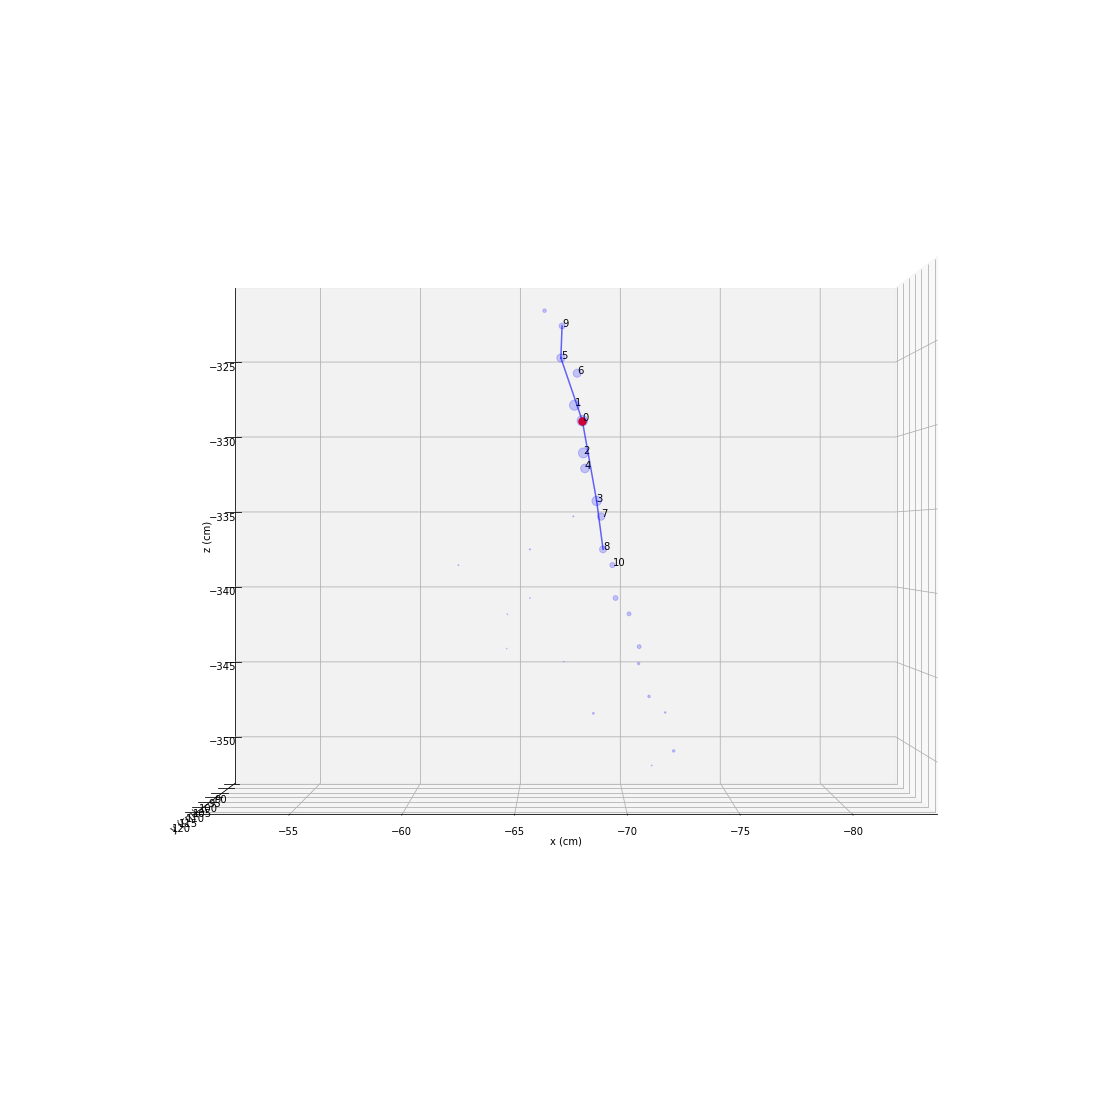

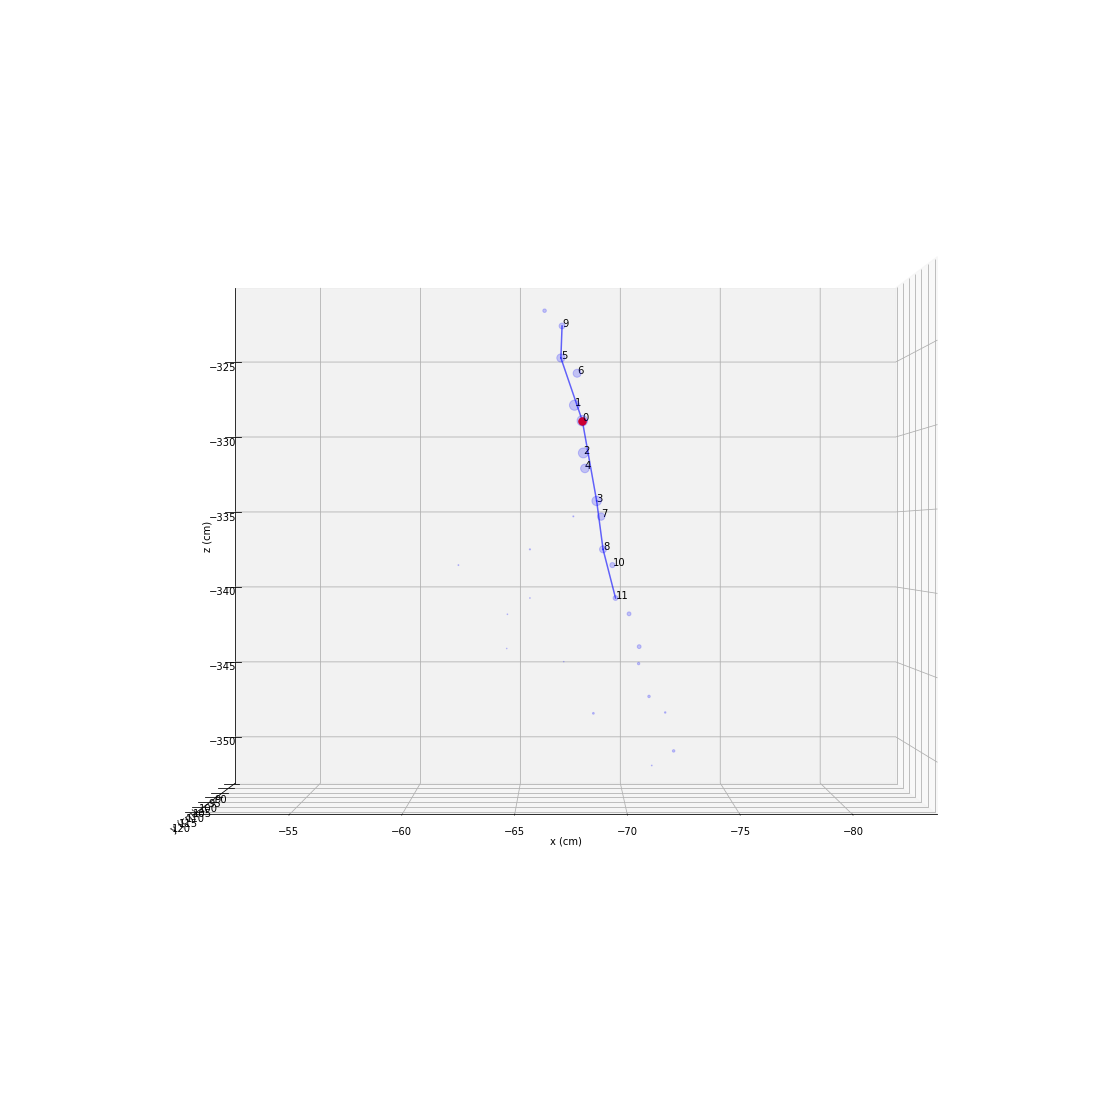

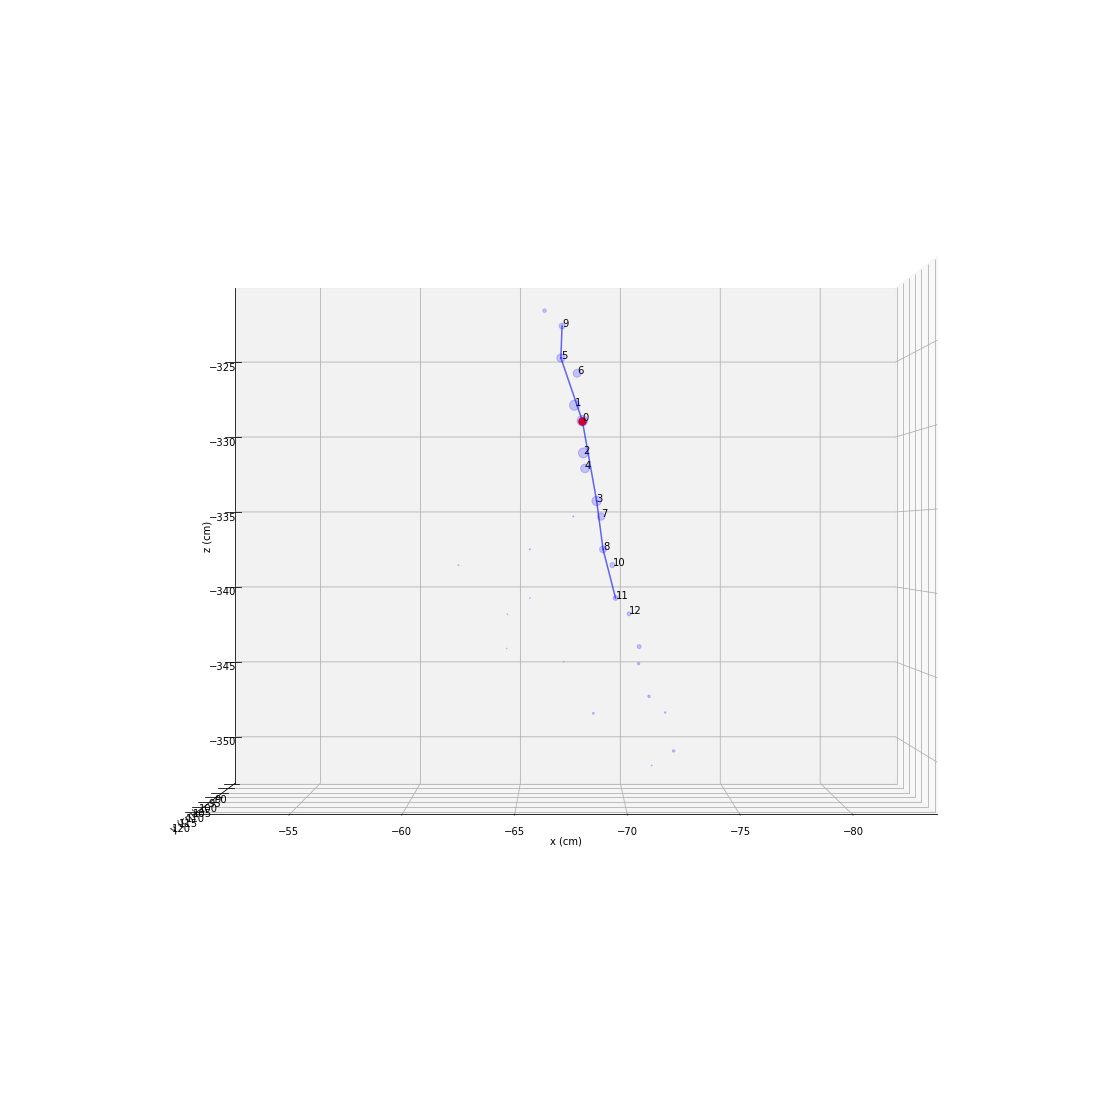

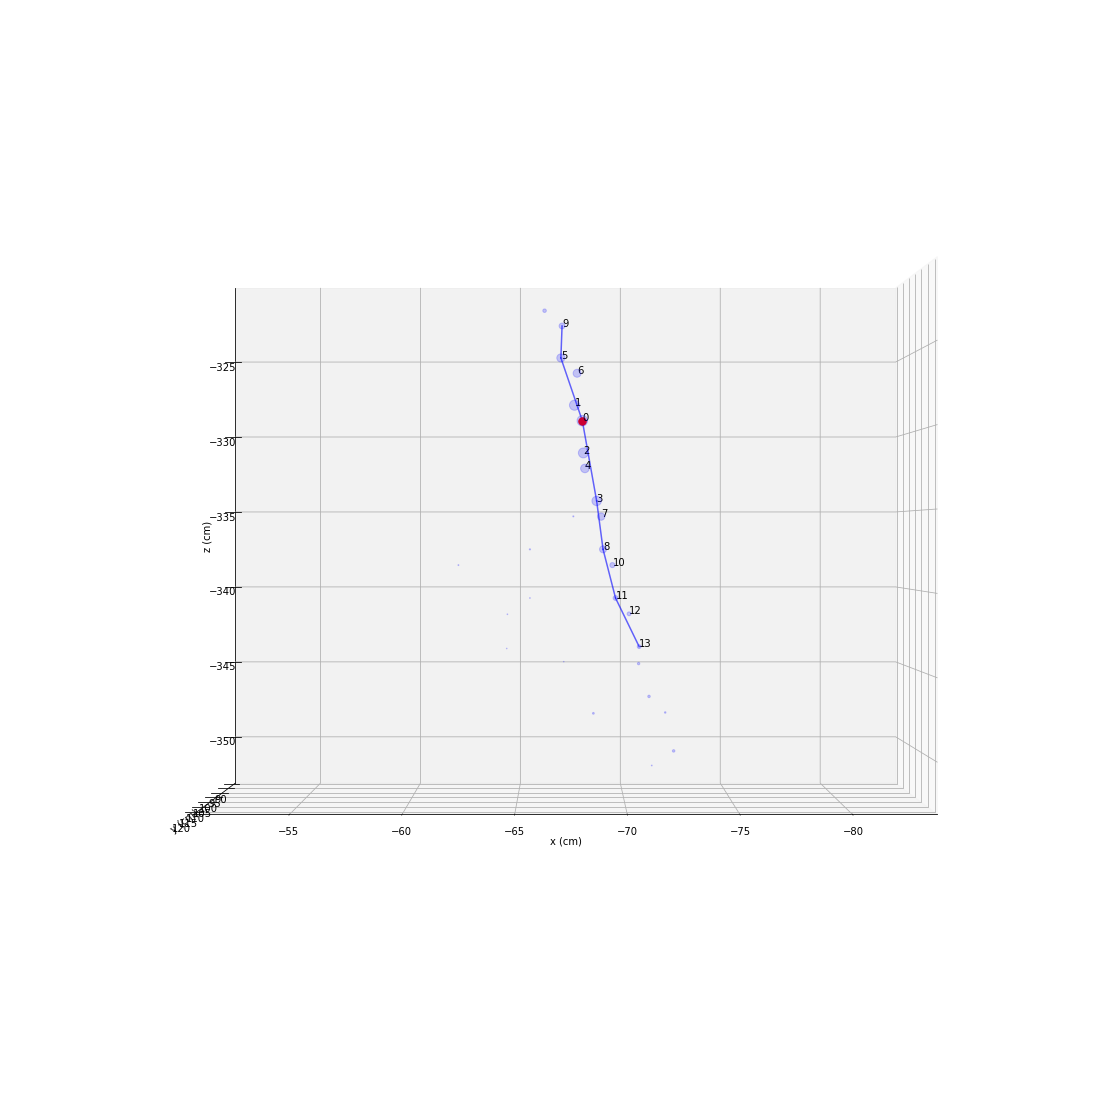

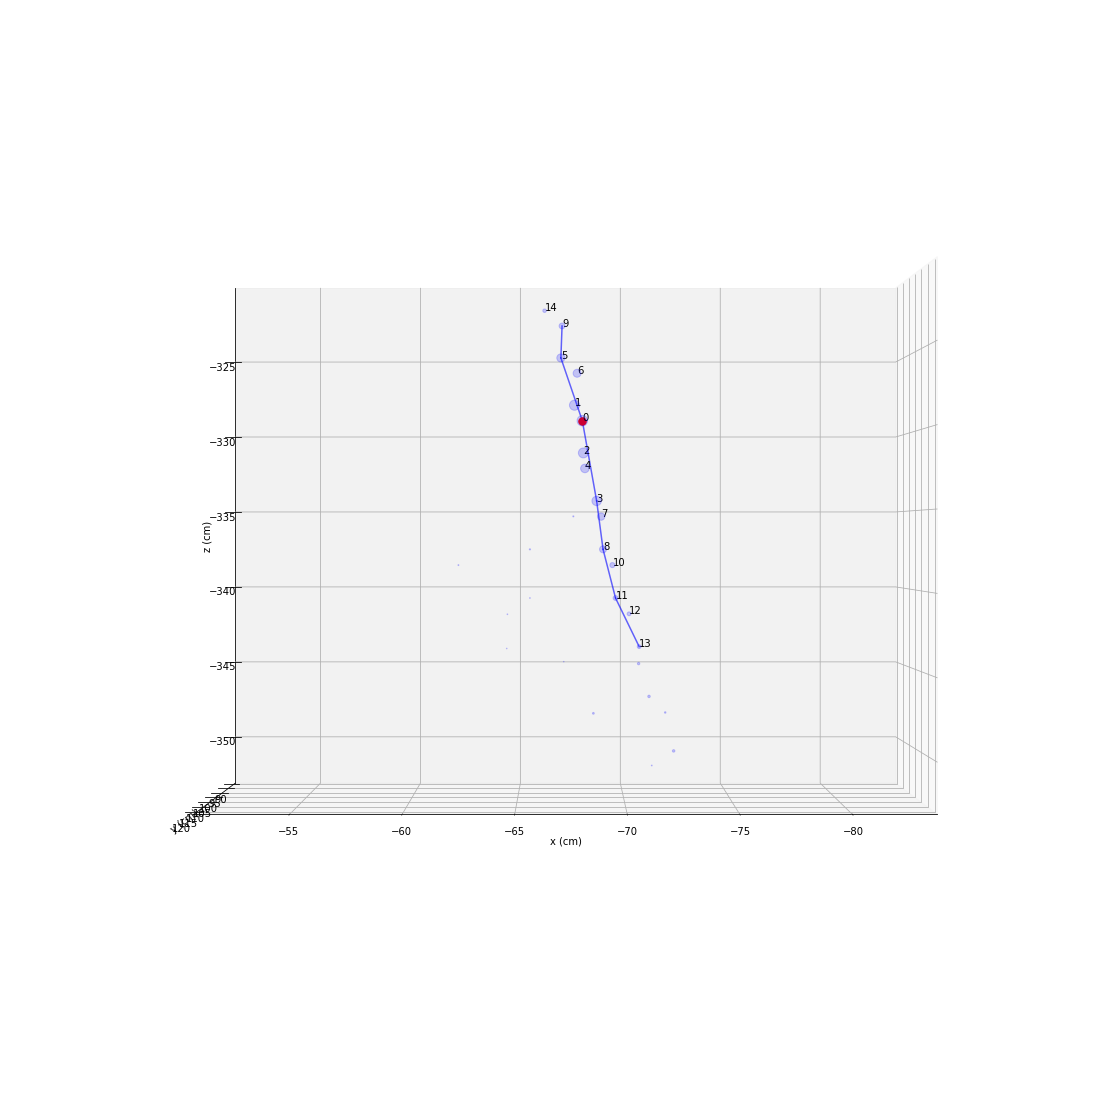

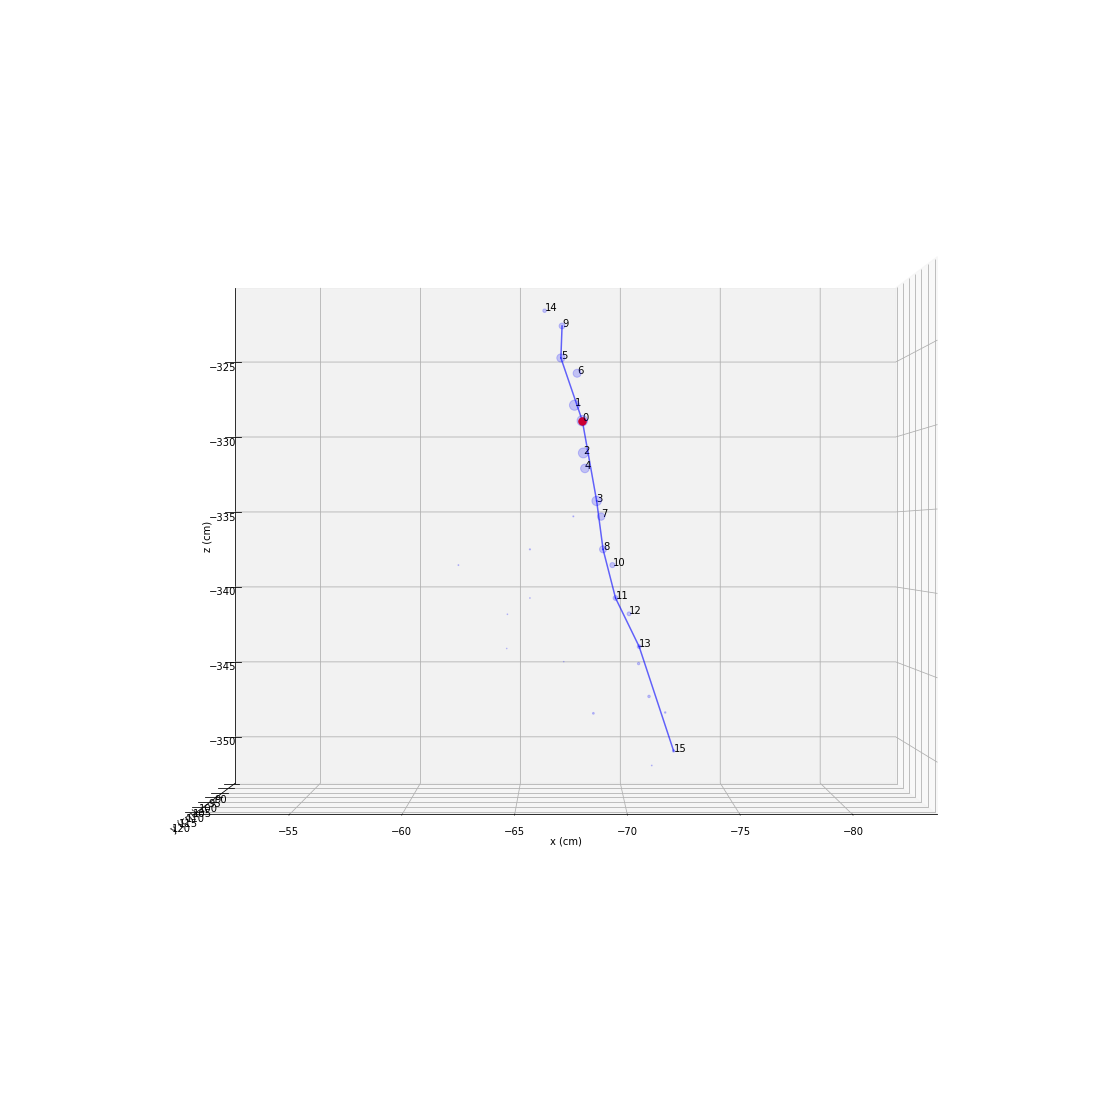

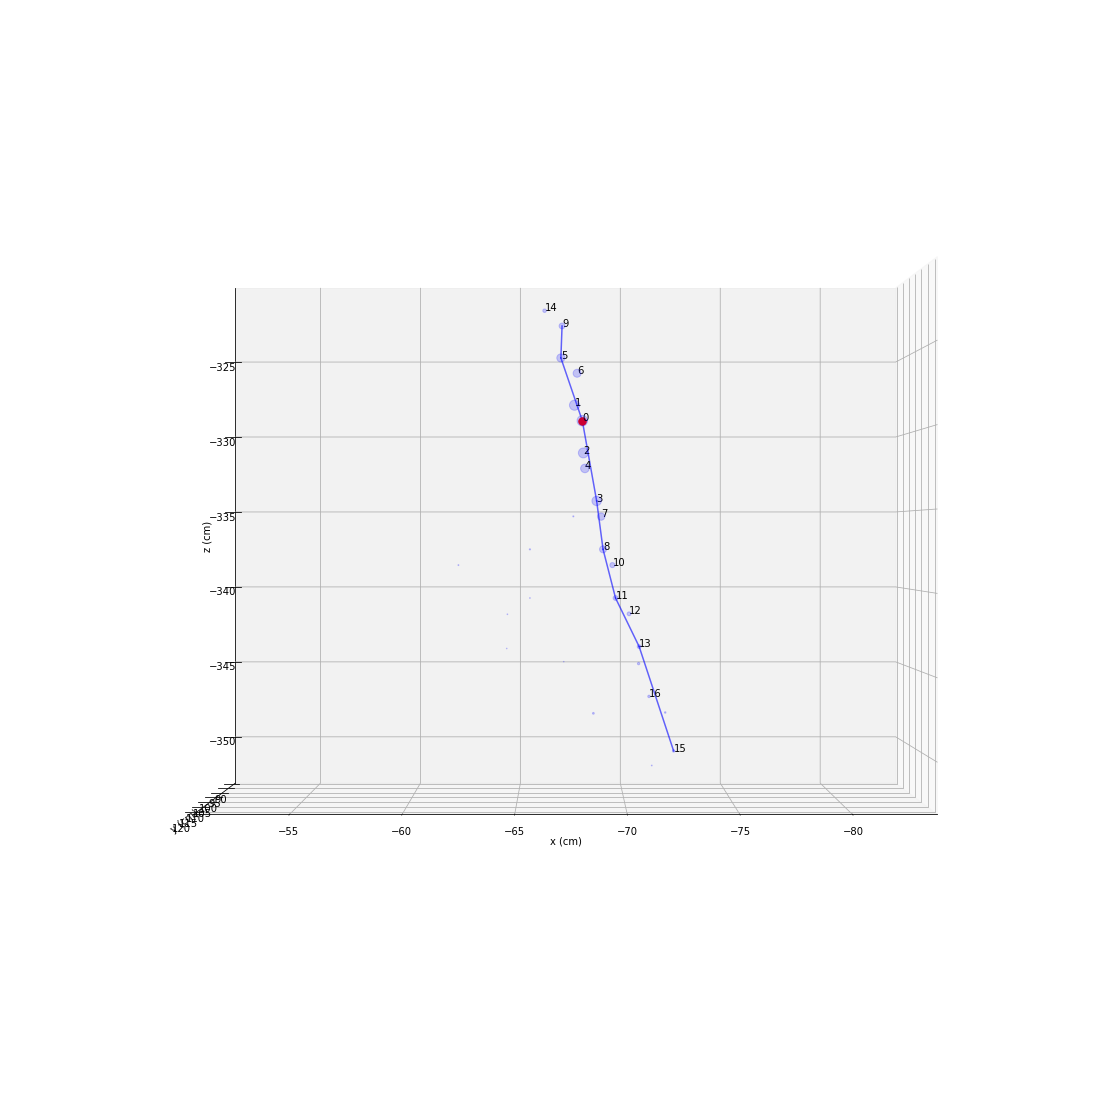

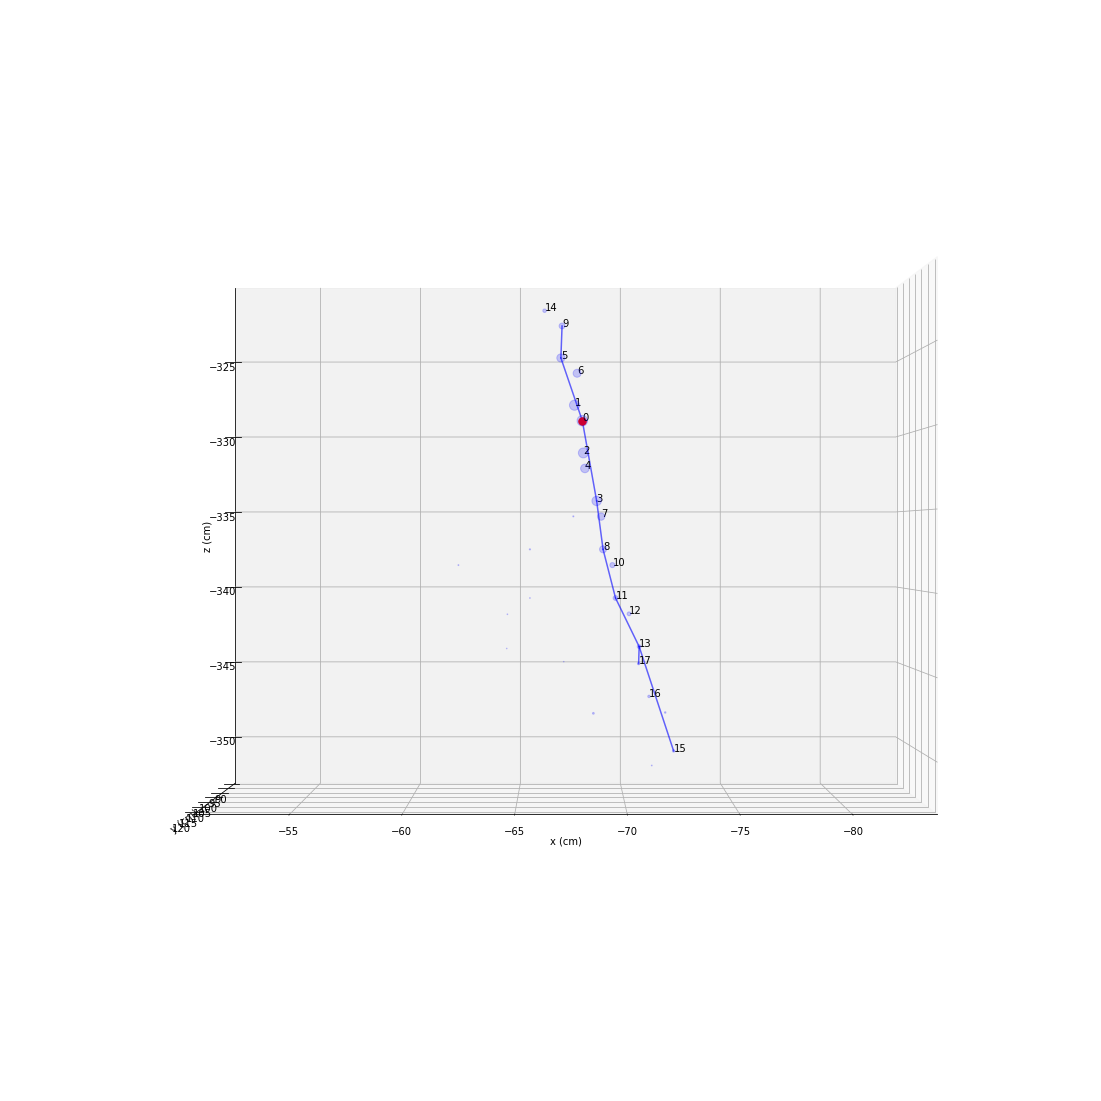

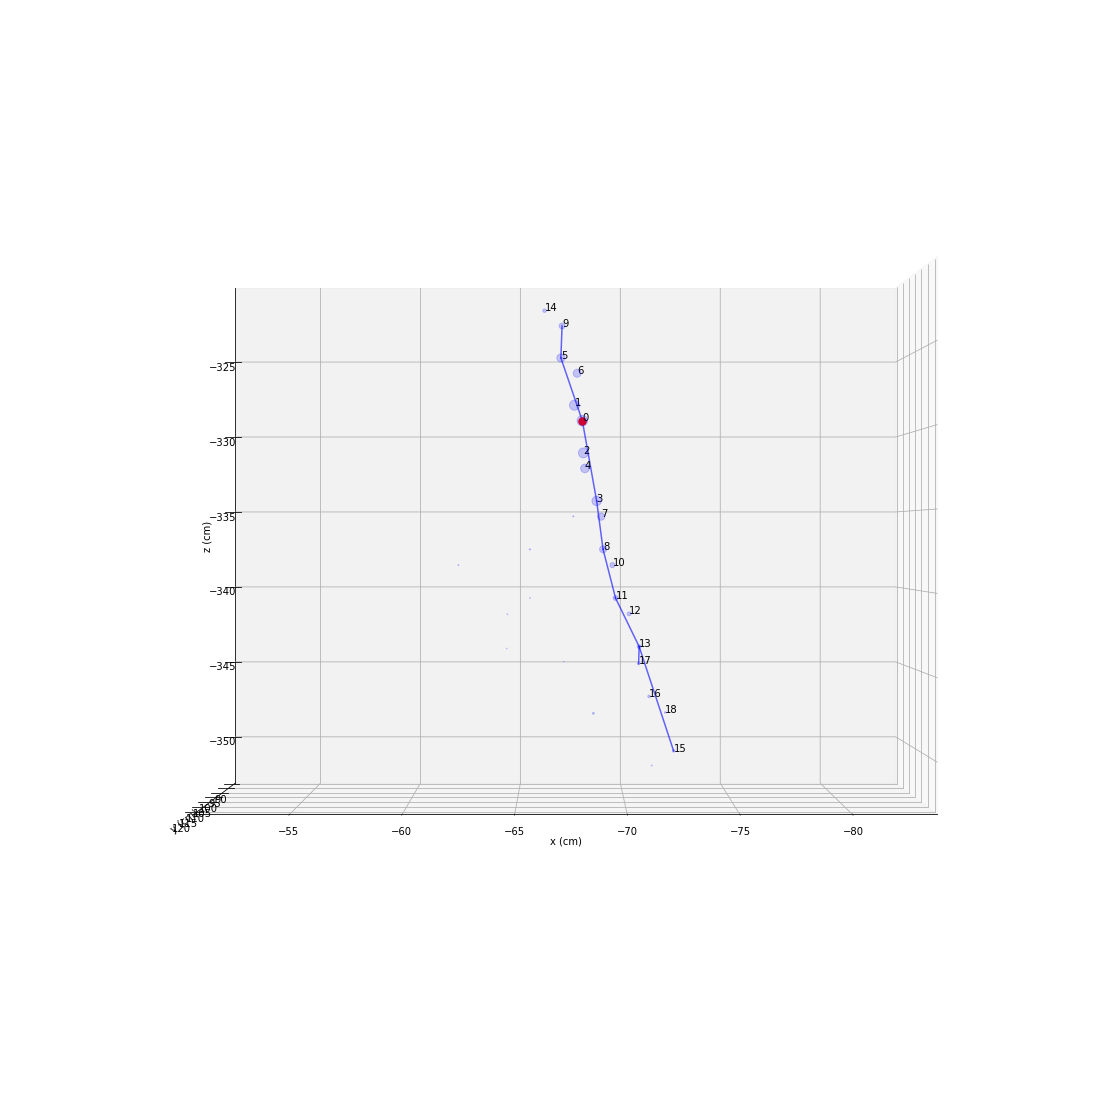

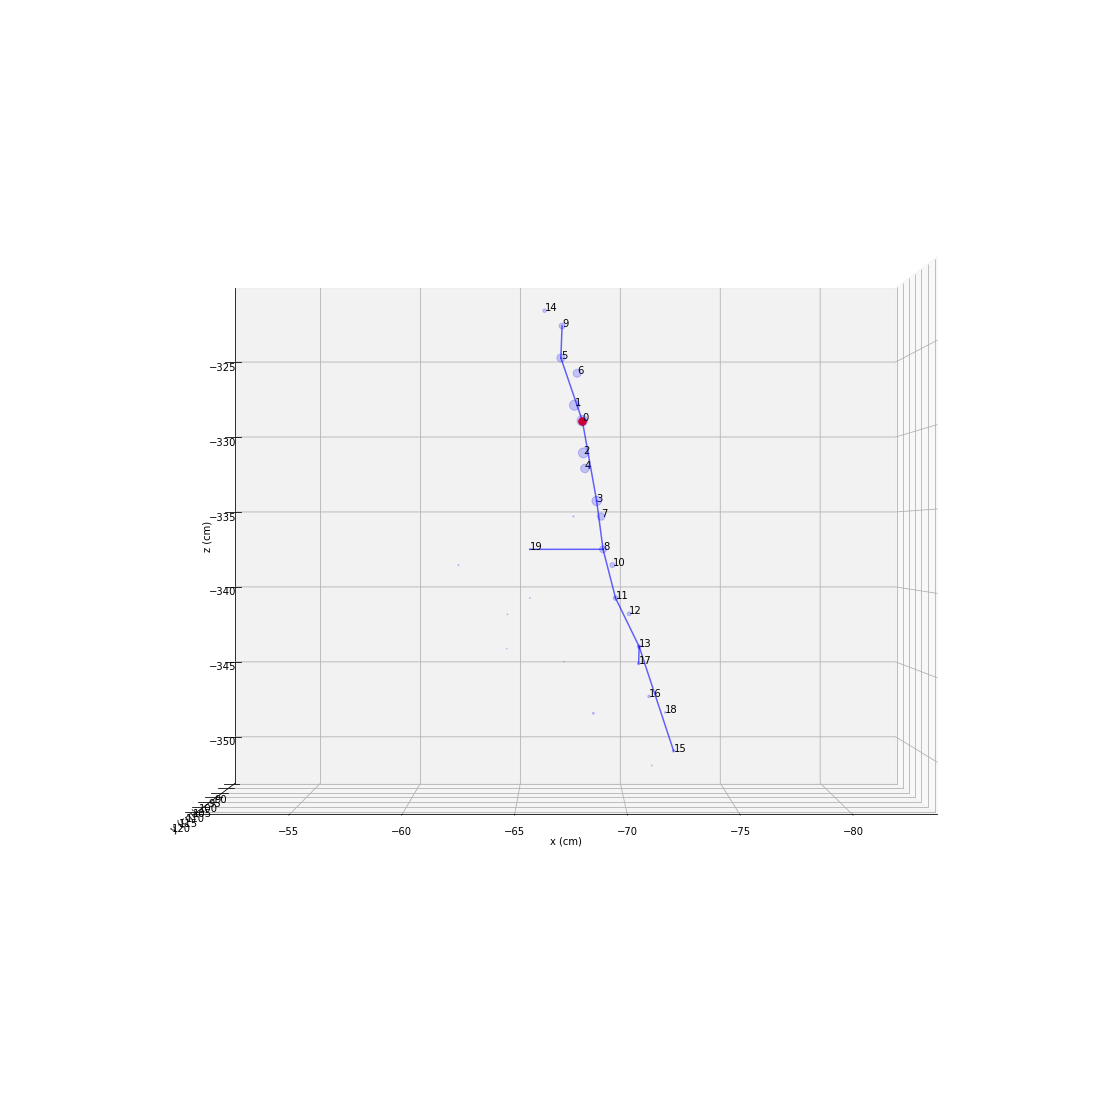

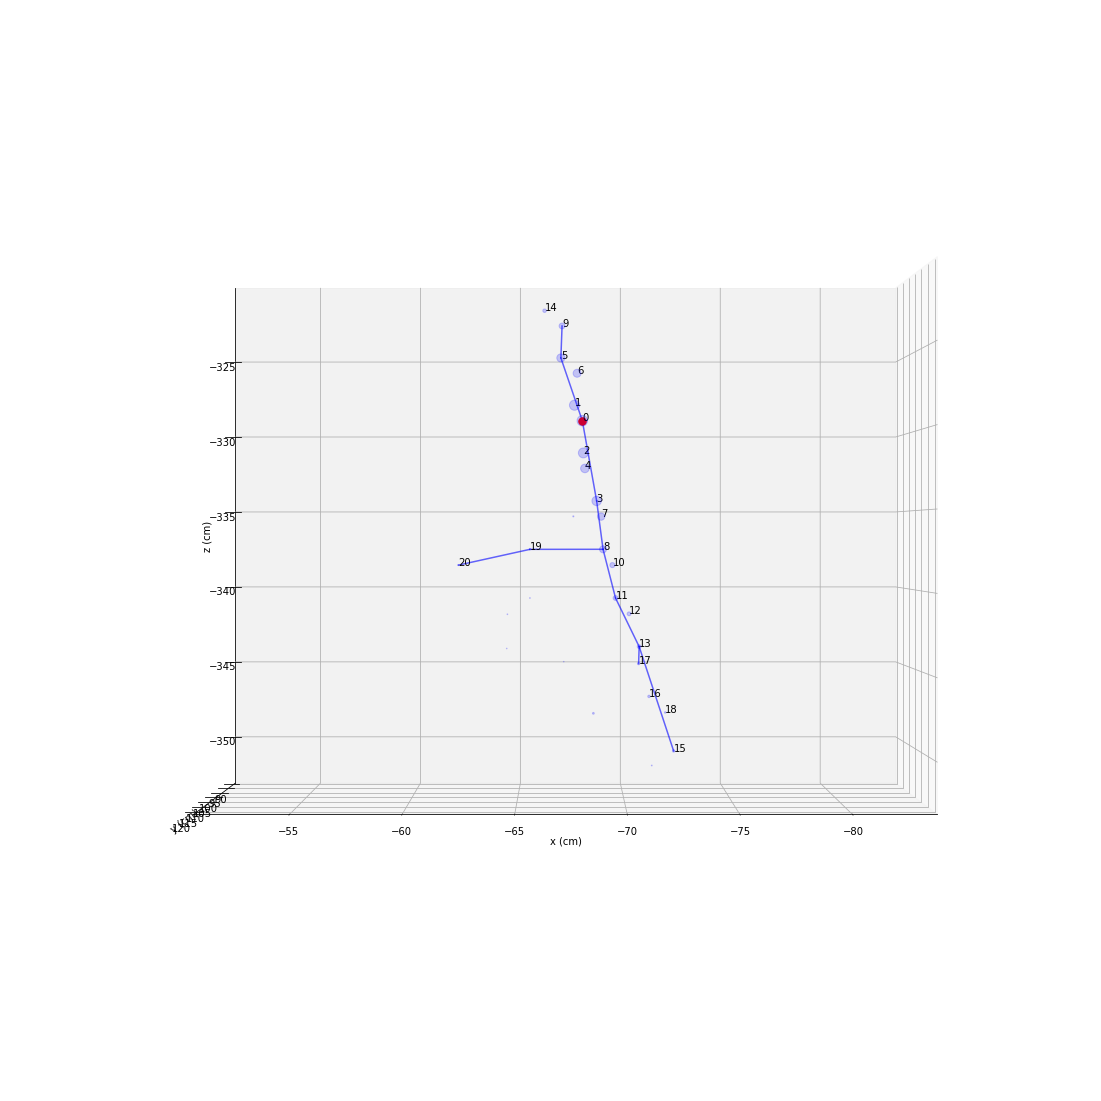

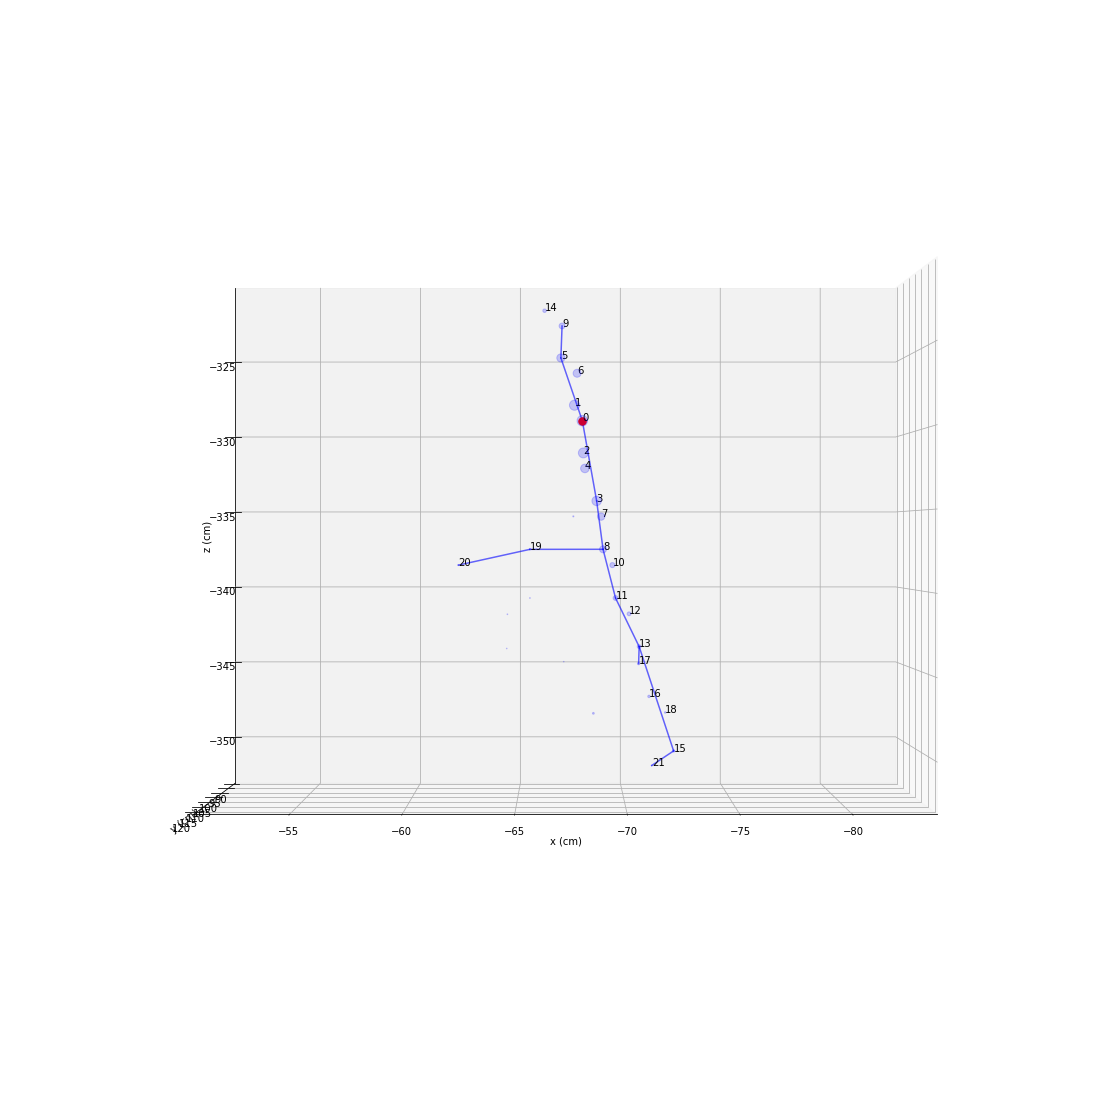

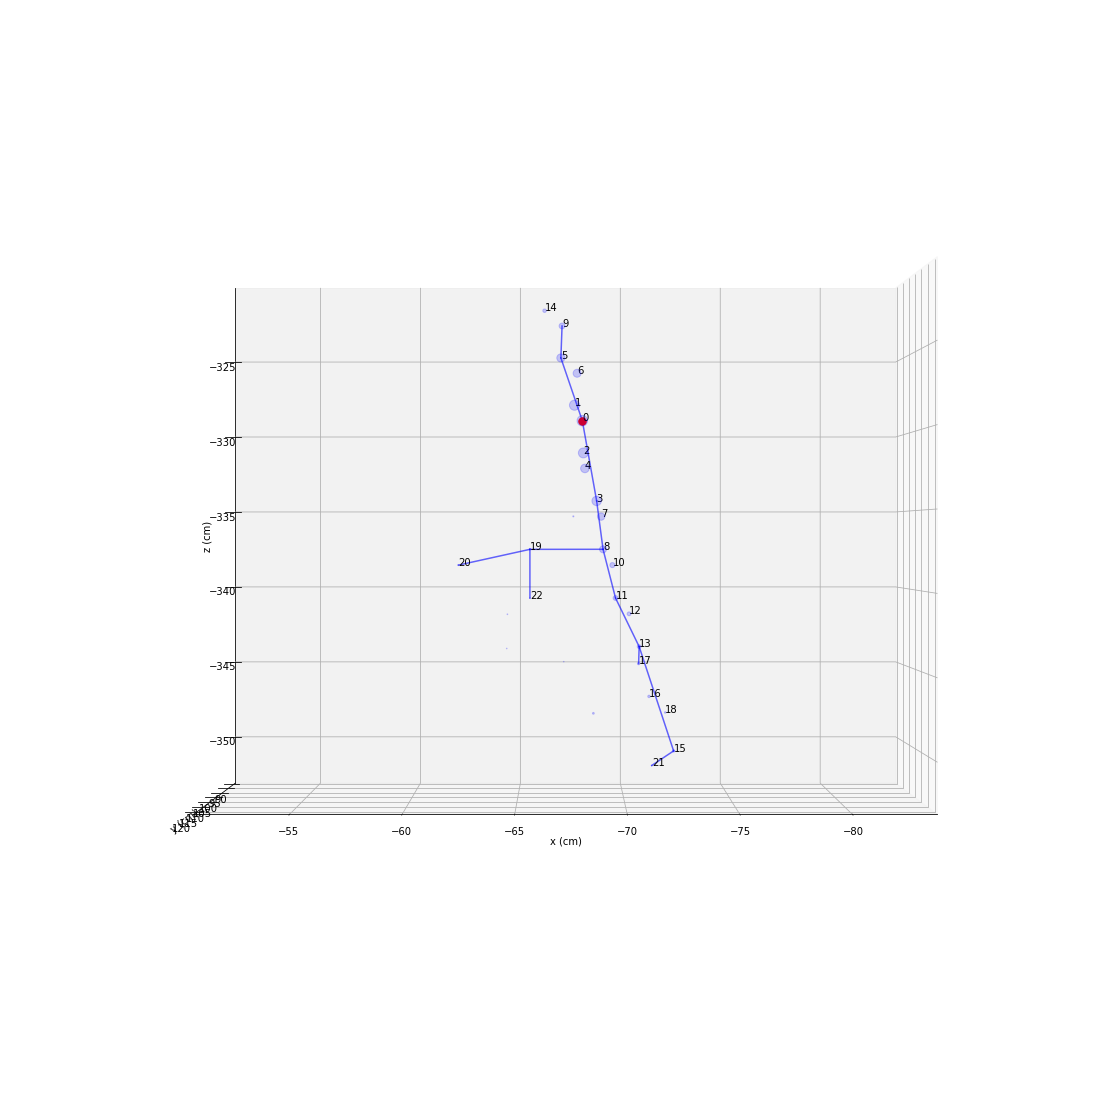

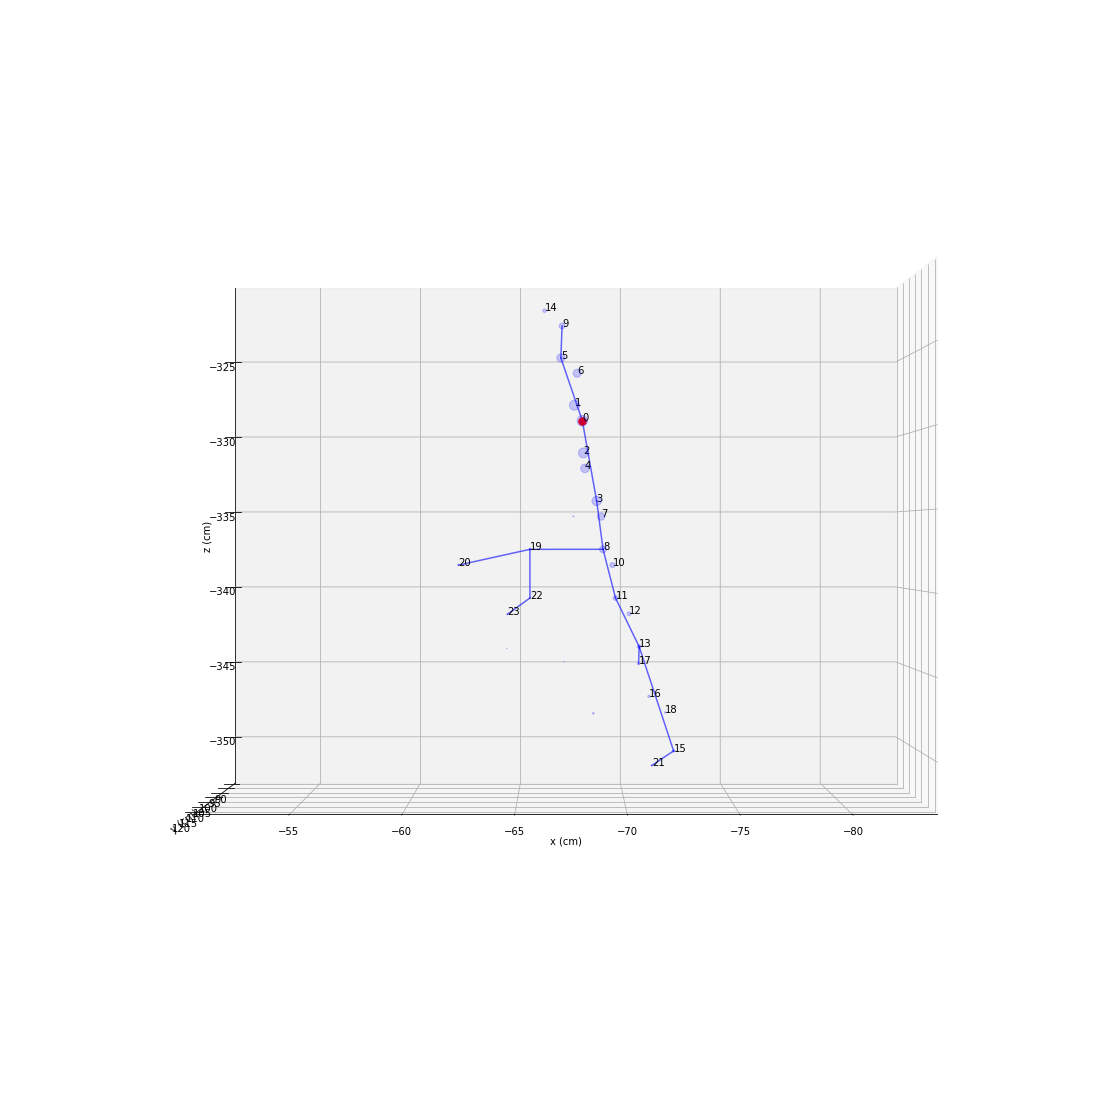

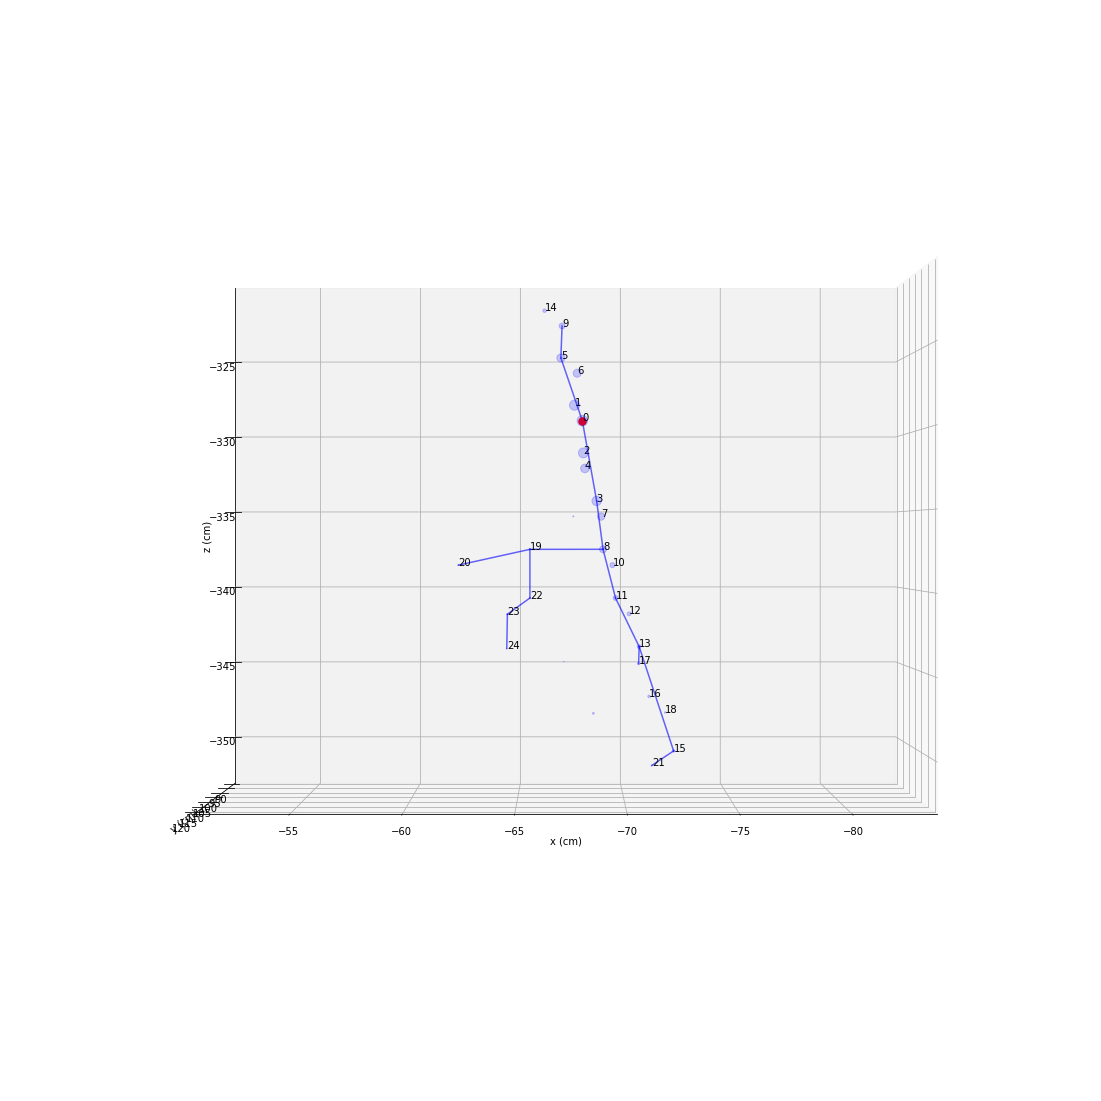

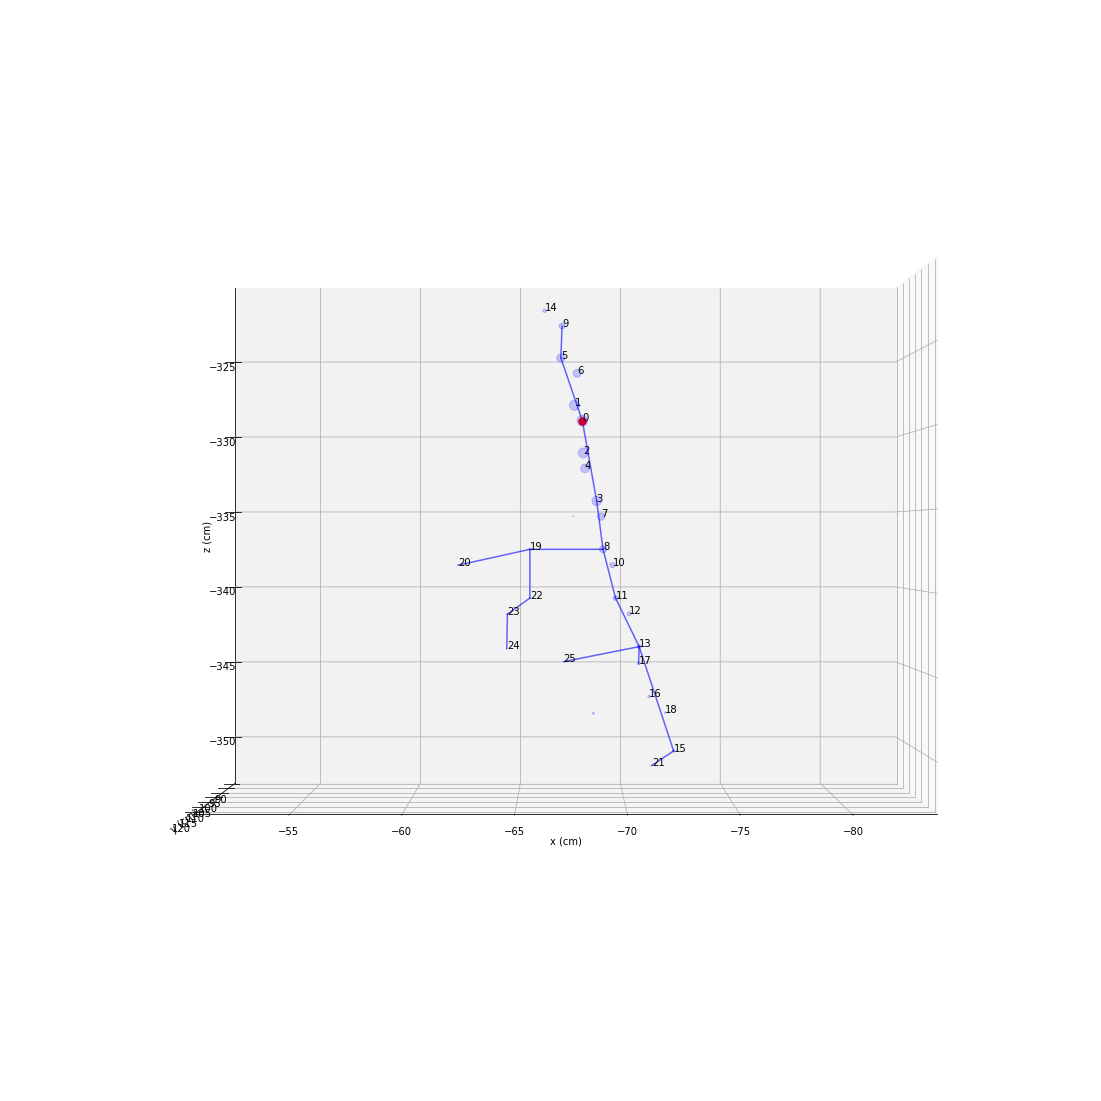

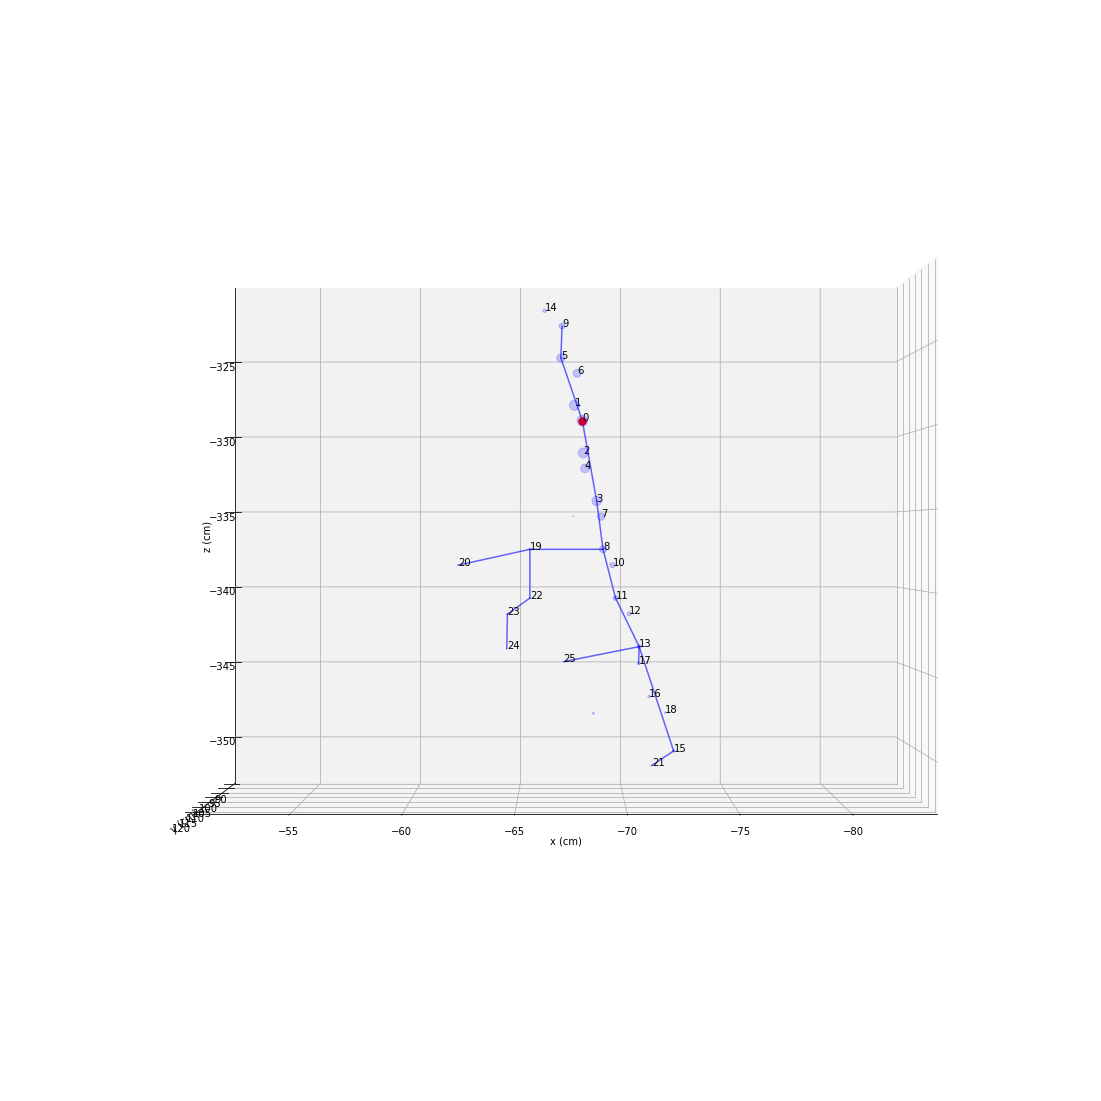

In [43]:
%matplotlib inline
MAX_ITER = 30
ANGLE_THR = 1.5 # ~ 85 degrees
DST_threshold = 2 # 2 cm - if the LC are further than 2 cm apart, we connect them with an edge
all_edges, all_nodes = [], []

for MAX_ITER in range(28):
    create_graph(lc_data, vx, vy, vz, ve, vi, DST_threshold=2, ANGLE_THR=1.5, sort_by_z=False, MAX_ITER=MAX_ITER)

In [49]:
%matplotlib widget

def create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigT, DST_threshold=2):
    # Project the poits on pca
    edges = {}

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Reconstruction of a pion in a high-pileup environment\nLayer Clusters")
    ax.set(xlabel="x (cm)", ylabel="y (cm)", zlabel="z (cm)")

    for bigT in bigTracksters:

        vxt = vx[bigT]
        vyt = vy[bigT]
        vzt = vz[bigT]
        vet = ve[bigT]
        vit = vi[bigT]

        bxt = bx[bigT]
        byt = by[bigT]
        bzt = bz[bigT]
        bet = be[bigT]

        pca = WPCA(n_components=3)
        positions = np.array((vxt, vyt, vzt)).T
        vet_array = np.array(vet).reshape(-1,1)
        vet_array = np.tile(vet_array,(1, 3))
        pca.fit(positions, weights = vet_array)
        components = pca.components_
        eigenvalues = pca.explained_variance_

        edges[(-1, -1)] = (seed_coord, seed_coord)

        ax.scatter(vxt, vyt, vzt, s=vet*bubble_size, alpha=0.2, c="blue", zorder=-5, label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        seed_lc_idx = trk_data.layer_cluster_seed[bigT]
        ax.scatter(bxt, byt, bzt, s=bet*bubble_size/5, c="red", label=f"{len(vet)} LC: {sum(vet):.2f} GeV")

        segment_start = np.array([bxt, byt, bzt])
        segment_end = np.array([bxt+components[0][0],
                                byt+components[0][1],
                                bzt+components[0][2]])

        data = [[x,y,z,e,i,j] for x,y,z,e,i,j in zip(vxt, vyt, vzt, vet, vit, range(len(vxt)))]

        # project each LC to the principal component
        min_p, max_p = (0,0,99999), (0,0,-99999)
        for x,y,z,e,i,j in data:

            dist, closest_point = project_lc_to_pca(np.array([x,y,z]), segment_start, segment_end)

            z_cl = closest_point[2]
            if min_p[2] > z_cl:
                min_p = closest_point
            if max_p[2] < z_cl:
                max_p = closest_point
                
            if dist > DST_threshold:
                # find distance to closest edge
                min_dist, min_edge, closest_point_edge, closest_endpoint, closest_endpoint_id =  find_dist_to_closest_edge(np.array([x,y,z]), edges)
                if min_dist > DST_threshold:
                    # plot the new edge
                    edges[(closest_endpoint_id, j)] = (closest_point_edge, point)
                    ax.plot([x, closest_point[0]], [y, closest_point[1]], [z, z_cl], c='blue', alpha=0.4)
                    # add it to the edge list

        break

    ax.plot([min_p[0], max_p[0]], [min_p[1], max_p[1]], [min_p[2], max_p[2]], c='blue', alpha=0.4)

    set_axes_equal(ax)
    plt.show()


In [46]:
%matplotlib widget
create_graph_pca(vx, vy, vz, ve, vi, bx, by, bz, be, bigT, DST_threshold=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

-322.1395691980875
-323.2194113578979
-325.14648203914265
-326.23866720604684
-328.2766822231611
-329.2743816639103
-331.28733286031434
-332.3577332539017
-334.3779319099496
-335.41343618103707
-336.2556190051045
-337.2608921345115
-337.4279402918366
-337.5194935229707
-338.4718343530798
-339.9440796541574
-340.51124856629195
-341.45740281878693
-341.1116755945586
-343.3342541172739
-343.8009318435739
-343.2149540200291
-344.9189706232028
-346.6602977586785
-347.7023222724155
-347.6198412334331
-349.91631992154504
-350.18532181018594
